In this challenge, you'll work with the [Life Expectancy dataset from Kaggle](https://www.kaggle.com/kumarajarshi/life-expectancy-who/home). The data is collected from the websites of the World Health Organisation (WHO) and World Bank (WB). The dataset contains annual variables for many of the countries in the world which are divided into several broad categories: immunization related factors, mortality factors, economical factors, and social factors.

* Data ranges from 2000-2015

Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it.

__First, load the dataset:__

In [185]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from scipy.stats import zscore
from sqlalchemy import create_engine
import warnings
import string
import re

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

In [186]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

life_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

## Functions

In [187]:
# Pass in a dataframe, a 'key' column, a list of columns to interpolate, and the limit direction.
# Loop through all of the columns and interpolate.
# Return the updated dataframe.
def interpolate_missing(df,key_column,column_list,limit_dir,**kwargs):
    interp_how = kwargs.get('interp_how','linear')
    for each_value in df[key_column].unique():
        for column in column_list:
            mask = (df[key_column] == each_value)
            df.loc[mask, column] = df.loc[mask, column].interpolate(limit_direction=limit_dir,method=interp_how)
    return df

In [188]:
# Update missing values for a variable, based on the values of a provided list of values for a key variable.
# You can choose whether to overwrite existing values for the target variable.
#
# Ex:
# update_df_via_index(life_df,'Country',['South Sudan'],
#                    ['Alcohol','Polio','Hepatitis b','Diphtheria'],
#                    south_sudan_neighbors,debug=True)
def update_df_via_index(df,find_col,find_col_list,upd_col,neighbors,**kwargs):
    overwrite = kwargs.get('overwrite',False)
    debug = kwargs.get('debug',False)
    
    for find_col_val in find_col_list:
        print("* Updating data for {}: {}".format(find_col,find_col_val))
        for this_col in upd_col:
            if (debug):
                print("** Updating column: {}".format(this_col))
            # Skip 2015 because there are a LOT of missing values across the board for this year.
            # We can deal with them later.
            upd_df = df.loc[(df['Country'].isin(neighbors))\
                            & (df['Year'] < 2015)][['Year',this_col]]\
                       .groupby(['Year']).mean()
            for each_year in upd_df.index:
    # Get the index for the row we want to update
                upd_index = int(df.loc[(df[find_col] == find_col_val) & (df['Year'] == each_year)].index[0])
                if (debug):
                    print("update index: {}".format(upd_index))
                    print(df.at[upd_index,this_col])
    # Don't overwrite existing values unless explicitly told to
                if (pd.isnull(df.loc[upd_index,this_col]) or overwrite):
                    df.at[upd_index,this_col] = upd_df.loc[each_year]
                else:
                    if debug:
                        print("Not overwriting existing value: {}".format(df.loc[upd_index,this_col]))

In [189]:
# Check out the distribution of a variable. Nothing fancy
def quick_distplot(series,title):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.distplot(series)
    plt.suptitle(title)
    ax.set(yscale="log")
    plt.show()

In [190]:
def quick_boxplot(series,title,**kwargs):
    logscale = kwargs.get('logscale',True)
    fig, ax = plt.subplots(figsize=(15,5))
    sns.boxplot(data=series,orient='h')
    plt.suptitle(title)
    if logscale:
        ax.set(xscale="log")
    plt.show()

In [256]:
def get_tukey(df,tukey_col):
    q75, q25 = np.percentile(df[tukey_col], [75 ,25])
    iqr = q75 - q25
    tukey_dict = {}
    for threshold in np.arange(1,5.5,0.5):
        min_val = q25 - (iqr*threshold)
        max_val = q75 + (iqr*threshold)
#        print("The score threshold is: {}".format(threshold))
        num_outliers = len((np.where((df[tukey_col] > max_val) | (df[tukey_col] < min_val))[0]))
#        print("Number of outliers is: {}".format(num_outliers))
        tukey_dict.update({threshold: [min_val, max_val, num_outliers]})
    return tukey_dict

In [257]:
def get_zscore(df,z_col):
    z_scores = zscore(df[z_col])
    z_dict = {}
    for threshold in range(1,5):
        print("The score threshold is: {}".format(threshold))
# !!! Unfortunately these indices do not seem to be the indices for the whole dataframe, just some subset.
        print("The indices of the outliers:")
        outlier_indices = np.where(z_scores > threshold)
        print(outlier_indices)
        num_outliers = len((np.where(z_scores > threshold)[0]))
        print("Number of outliers is: {}".format(num_outliers))
        z_dict.update({threshold: outlier_indices})
    return z_dict

In [258]:
def find_outliers(df,key_col,outl_col,**kwargs):
    return_outliers = kwargs.get('return_outliers',False)
    outliers_list = []
    for key_val in df[key_col].unique():
        outlier_tukey = get_tukey(df.loc[df[key_col] == key_val],outl_col)
        for thr_key in sorted(outlier_tukey):
            if ((outlier_tukey[thr_key][2] == 0) or (thr_key == 5.0)):
                print("{}: {}: Found {} outliers at threshold == {}: {}".format(key_col,
                                                                            key_val,
                                                                            outlier_tukey[thr_key][2],
                                                                            thr_key,
                                                                            outlier_tukey[thr_key]))
                if (thr_key != 1.0):
                    print(outlier_tukey)
                    outliers_list.append(key_val)
                break
    if return_outliers:
        return outliers_list

## Data cleanup

__Detect the problems with the data such as missing values and outliers.__ Are there any nonsense values that seem to be stemmed from the data collection?

__For the missing values, discuss which technique would be the most suitable one in filling out these values.__

__Countries with partially missing data:__
* The areas now known as Sudan and South Sudan engaged in a civil war with each other until a peace treaty was signed in 2005; South Sudan became its own nation in 2011. It does not have values for GDP or the Composition of resources variables before that year.
* Timor-Leste did not exist as a sovereign nation until May 2002--it was formerly a part of Indonesia.
* Montenegro was originally a part of Yugoslavia, then was part of a confederacy with Serbia. It became an independent nation in 2006.
* The Democratic People's Republic of Korea is North Korea. It simply does not make a lot of this data available, if it is even collected.
* Somalia has been in some state of civil war/unrest since the early 1990s, with its current central government established in 2012.

In [191]:
life_df.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


In [192]:
life_df.loc[life_df['Year'] == 2015].describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,183.0,183.000000,183.000000,183.000000,6.000000,183.000000,174.000000,183.000000,181.000000,183.000000,183.000000,2.000000,183.000000,183.000000,154.000000,1.420000e+02,181.000000,181.000000,173.000000,173.000000
mean,2015.0,71.616940,152.863388,23.803279,5.288333,2.383906,82.425287,1502.901639,42.754144,31.612022,83.207650,7.080000,84.633880,0.660656,7185.331746,1.109741e+07,4.534807,4.575691,0.691740,12.927168
std,0.0,8.123706,97.561184,83.683762,4.038115,27.461032,24.008492,7842.394928,20.685702,107.779778,24.245778,1.527351,22.162793,1.344702,11697.508913,2.896230e+07,4.099425,4.180785,0.153412,2.912366
min,2015.0,51.000000,1.000000,0.000000,0.010000,0.000000,6.000000,0.000000,2.500000,0.000000,5.000000,6.000000,6.000000,0.100000,33.681223,2.966000e+03,0.100000,0.100000,0.347000,4.900000
25%,2015.0,65.750000,74.000000,0.000000,2.492500,0.000000,78.750000,0.000000,24.300000,0.000000,83.000000,6.540000,83.500000,0.100000,766.008101,2.680710e+05,1.500000,1.500000,0.565000,10.800000
50%,2015.0,73.900000,138.000000,2.000000,5.285000,0.000000,93.000000,17.000000,48.600000,3.000000,93.000000,7.080000,93.000000,0.100000,2916.228918,2.076086e+06,3.500000,3.400000,0.723000,13.100000
75%,2015.0,76.950000,213.000000,17.000000,8.017500,0.000000,97.000000,202.000000,61.400000,21.000000,97.000000,7.620000,97.000000,0.400000,7290.107448,9.940296e+06,6.500000,6.400000,0.798000,15.000000
max,2015.0,88.000000,484.000000,910.000000,10.660000,364.975229,99.000000,90387.000000,77.600000,1100.000000,99.000000,8.160000,99.000000,9.300000,66346.522670,2.581621e+08,26.700000,27.300000,0.948000,20.400000


### Dataframe column names

In [193]:
# Strip leading/trailing spaces from column names.
# Turn double spaces into single spaces in column names.
# Capitalize the first word in the column name.

life_df.rename(lambda x: re.sub('\s\s',' ',x.strip().capitalize()),
                         axis='columns',
               inplace=True)
print(life_df.columns)

Index(['Country', 'Year', 'Status', 'Life expectancy', 'Adult mortality',
       'Infant deaths', 'Alcohol', 'Percentage expenditure', 'Hepatitis b',
       'Measles', 'Bmi', 'Under-five deaths', 'Polio', 'Total expenditure',
       'Diphtheria', 'Hiv/aids', 'Gdp', 'Population', 'Thinness 1-19 years',
       'Thinness 5-9 years', 'Income composition of resources', 'Schooling'],
      dtype='object')


### Countries that don't have a full complement of data, 2000-2015

These countries only have one year of data available. These rows are missing some crucial values like Population, Life Expectancy, and Adult Mortality. They are also pretty tiny countries whose exclusion will not change the overall results of any analysis we perform. Let's drop these rows.

In [194]:
countries = life_df.groupby(['Country'])[['Country']].count()
oneoff_country_list = countries.loc[countries['Country'] < 16].index
print(oneoff_country_list)

Index(['Cook Islands', 'Dominica', 'Marshall Islands', 'Monaco', 'Nauru',
       'Niue', 'Palau', 'Saint Kitts and Nevis', 'San Marino', 'Tuvalu'],
      dtype='object', name='Country')


In [195]:
life_df.loc[life_df['Country'].isin(oneoff_country_list)]

,Country,Year,Status,Life expectancy,Adult mortality,Infant deaths,Alcohol,Percentage expenditure,Hepatitis b,Measles,...,Polio,Total expenditure,Diphtheria,Hiv/aids,Gdp,Population,Thinness 1-19 years,Thinness 5-9 years,Income composition of resources,Schooling
624,Cook Islands,2013,Developing,NaN,NaN,0,0.01,0.000000,98.0,0,...,98.0,3.58,98.0,0.1,NaN,NaN,0.1,0.1,NaN,NaN
769,Dominica,2013,Developing,NaN,NaN,0,0.01,11.419555,96.0,0,...,96.0,5.58,96.0,0.1,722.756650,NaN,2.7,2.6,0.721,12.7
1651,Marshall Islands,2013,Developing,NaN,NaN,0,0.01,871.878317,8.0,0,...,79.0,17.24,79.0,0.1,3617.752354,NaN,0.1,0.1,NaN,0.0
1716,Monaco,2013,Developing,NaN,NaN,0,0.01,0.000000,99.0,0,...,99.0,4.30,99.0,0.1,NaN,NaN,NaN,NaN,NaN,NaN
1813,Nauru,2013,Developing,NaN,NaN,0,0.01,15.606596,87.0,0,...,87.0,4.65,87.0,0.1,136.183210,NaN,0.1,0.1,NaN,9.6
1910,Niue,2013,Developing,NaN,NaN,0,0.01,0.000000,99.0,0,...,99.0,7.20,99.0,0.1,NaN,NaN,0.1,0.1,NaN,NaN
1959,Palau,2013,Developing,NaN,NaN,0,NaN,344.690631,99.0,0,...,99.0,9.27,99.0,0.1,1932.122370,292.0,0.1,0.1,0.779,14.2
2168,Saint Kitts and Nevis,2013,Developing,NaN,NaN,0,8.54,0.000000,97.0,0,...,96.0,6.14,96.0,0.1,NaN,NaN,3.7,3.6,0.749,13.4
2217,San Marino,2013,Developing,NaN,NaN,0,0.01,0.000000,69.0,0,...,69.0,6.50,69.0,0.1,NaN,NaN,NaN,NaN,NaN,15.1
2713,Tuvalu,2013,Developing,NaN,NaN,0,0.01,78.281203,9.0,0,...,9.0,16.61,9.0,0.1,3542.135890,1819.0,0.2,0.1,NaN,0.0


In [196]:
life_df = life_df[~life_df['Country'].isin(oneoff_country_list)]

### Columns with missing values

1. __Alcohol__ - This is average liters of pure alcohol consumed annually, per person. Can either use a mean or interpolate for all of those missing 2015 entries.
    * South Sudan has NO data whatsoever--this is problematic because some Googling suggests alcohol is not only consumed there, [but in relatively large quantities for some](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5012008/). We can calculate the mean of its neighbors for each year, and use those values.

In [197]:
# Make a list of South Sudan's neighbors--we can use the list to impute missing values for South Sudan.
south_sudan_neighbors = ['Sudan','Ethiopia','United Republic of Tanzania','Congo','Central African Republic']

In [198]:
# There are missing values for other variables that we can also fill in with the mean of South Sudan's neighbors.
# Let's do it all in one shot.
update_df_via_index(life_df,
                    'Country',['South Sudan'],
                    ['Alcohol','Polio','Hepatitis b','Diphtheria','Thinness 1-19 years','Thinness 5-9 years'],
                    south_sudan_neighbors)

* Updating data for Country: South Sudan


In [199]:
# Montenegro has the only other non-2015 NaN. Let's fill in this NaN with the mean for Montenegro.
montenegro_alcohol_mean = life_df.loc[(life_df['Country'] == 'Montenegro')]['Alcohol'].mean()
upd_index = int(life_df.loc[(life_df['Country'] == 'Montenegro') & (life_df['Year'] == 2005)].index[0])
life_df.at[upd_index,'Alcohol'] = montenegro_alcohol_mean

# HEY LOOK HERE

In [200]:
# This is a nice way to just fill in the 2015 NaNs for Alcohol.
# We can do this for all of the affected 2015 variables in one shot,
# once we've finished cleaning up the rest of the data.

# Revisit this.

life_df = interpolate_missing(life_df,
                             'Country',
                             ['Alcohol'],
                             'both',interp_how='linear')

In [201]:
def what_is_this(x):
    try:
        if x.isnumeric():
            return True
    except AttributeError:
        return True

2. __Hepatitis B__ - Immunization coverage among one-year olds as a percentage. The immunization programs of some countries do not cover 1-year olds:
    * Denmark *
    * Finland *
    * [Hungary](https://www.rmc.hu/en/services/required-and-optional-vaccines) (focuses on 12 year olds)
    * Iceland *
    * [Japan](https://www.ncbi.nlm.nih.gov/pubmed/29929825) (not introduced until 2016)
    * Norway *
    * [Slovenia](https://www.efvv.eu/slovenia-2/#bg) (focuses on 5-6 year olds)
    * [Switzerland](https://smw.ch/article/doi/smw.2017.14409/) (focuses primarily on 11-15 year olds)
    * United Kingdom of Great Britain and Northern Ireland *
    
    \*These European countries ["have very low endemicity and consider hepatitis B to be a limited public health problem, thus not justifying additional expense"](http://www.euro.who.int/en/health-topics/disease-prevention/vaccines-and-immunization/vaccine-preventable-diseases/hepatitis-b).

    Since all of these countries except Japan _did_ have vaccination policies 2000-2015, it probably makes sense to interpolate from any neighbors who have data. Japan will just get all zeroes for this variable.

    I already generated some values for South Sudan above.
    
    Only a handful of countries remain, and they are just missing values for 2015. Interpolation will work well here.

In [202]:
european_neighbors = ['Sweden','Germany','Ireland','Belgium','France']

In [203]:
# Fill in Hep B values for European countries who vaccinate, but don't vaccinate at 1 year
# based on their neighbors' rates of vaccination
update_df_via_index(life_df,
                    'Country',
                    ['Denmark','Finland','Iceland','Norway','Switzerland','United Kingdom of Great Britain and Northern Ireland'],
                    ['Hepatitis b'],
                    european_neighbors)

* Updating data for Country: Denmark
* Updating data for Country: Finland
* Updating data for Country: Iceland
* Updating data for Country: Norway
* Updating data for Country: Switzerland
* Updating data for Country: United Kingdom of Great Britain and Northern Ireland


In [204]:
east_european_neighbors = ['Slovakia','Austria','Croatia','Serbia','Romania']

In [205]:
# Fill in Hep B values for east European countries who vaccinate, but don't vaccinate at 1 year,
# based on their neighbors' rates of vaccination
update_df_via_index(life_df,
                    'Country',
                    ['Hungary','Slovenia'],
                    ['Hepatitis b'],
                    east_european_neighbors)

* Updating data for Country: Hungary
* Updating data for Country: Slovenia


In [206]:
# Japan didn't begin routine vaccinations for Hep B until 2016. Give them zeroes.
for upd_index in life_df.loc[(life_df['Country'] == 'Japan')].index:
    life_df.at[upd_index,'Hepatitis b'] = 0

In [207]:
# Combine this with the Alcohol interpolation later ############
life_df = interpolate_missing(life_df,
                             'Country',
                             ['Hepatitis b','Bmi'],
                             'both',interp_how='linear')

3. __BMI__ - Body Mass Index, typical range is in the 20s-30s.

Sudan and South Sudan have no data. Impute from neighbors.

In [208]:
# Fill in BMI values for Sudan and South Sudan
update_df_via_index(life_df,
                    'Country',
                    ['Sudan','South Sudan'],
                    ['Bmi'],
                    south_sudan_neighbors)

* Updating data for Country: Sudan
* Updating data for Country: South Sudan


4. __Polio__ - Immunization rate among 1-year olds.
5. __Diphtheria__ - Immunization rate among 1-year olds.

These two columns have the same issues:

South Sudan doesn't have this data (already imputed based on neighbors' values).

Missing values for: Montenegro, 2000-2005; Timor-Leste, 2000-2001. Impute values from Serbia and Indonesia, respectively, for those countries/years.

In [209]:
# Fill in Polio vaccination values for Montenegro. This will only fill in NaNs
update_df_via_index(life_df,
                    'Country',
                    ['Montenegro'],
                    ['Polio','Diphtheria'],
                    ['Serbia'])

* Updating data for Country: Montenegro


In [210]:
# Fill in Polio vaccination values for Timor-Leste. This will only fill in NaNs
update_df_via_index(life_df,
                    'Country',
                    ['Timor-Leste'],
                    ['Polio','Diphtheria'],
                    ['Indonesia'])

* Updating data for Country: Timor-Leste


6. __Total expenditure__ - General government expenditure on health as a percentage of total government expenditure (%).

All of 2015 are NaNs. We can interpolate to fill in this year.

All NaNs for Somalia. We can try imputing based on neighbors and see how that looks.

All NaNs for Democratic People's Republic of Korea too. I don't think we can interpolate from neighbors here--North Korea is definitely in its own league. [This page](https://tradingeconomics.com/north-korea/health-expenditure-public-percent-of-government-expenditure-wb-data.html) suggests:

> Health expenditure, public (% of government expenditure) in North Korea was reported at __12%__ in 2006, according to the World Bank collection of development indicators, compiled from officially recognized sources.

So let's fill in 12% for North Korea and call it good.

NaNs for Iraq, 2000-2002. We can interpolate to fill in for these three years.

NaNs for South Sudan, 2000-2011. We can impute from Sudan for these years.

In [211]:
somalia_neighbors = ['Kenya','Djibouti','Ethiopia','Sudan']

In [212]:
# Fill in Total Expenditure for Somalia
update_df_via_index(life_df,
                    'Country',
                    ['Somalia'],
                    ['Total expenditure'],
                    somalia_neighbors)

* Updating data for Country: Somalia


In [213]:
# Fill in North Korea NaNs in Total expenditure with a value we sourced from elsewhere.
for upd_index in life_df.loc[(life_df['Country'] == 'Democratic People\'s Republic of Korea')].index:
    life_df.at[upd_index,'Total expenditure'] = 12.0

In [214]:
# Fill in Total expenditure for South Sudan. This will only fill in NaNs
update_df_via_index(life_df,
                    'Country',
                    ['South Sudan'],
                    ['Total expenditure'],
                    ['Sudan'])

* Updating data for Country: South Sudan


In [215]:
# Combine this with the Alcohol interpolation later ############
life_df = interpolate_missing(life_df,
                             'Country',
                             ['Total expenditure'],
                             'both',interp_how='linear')

7. __GDP__ - Gross Domestic Product per capita (in USD)

Some countries are missing values for just a few years--we may be able to interpolate values for them.

A lengthy list of countries are all NaNs in this column. The US is one of those countries, along with the UK. I'm really tempted to just drop this column because of these missing values--it bugs me that there's no data for the US in particular, when this should be readily available. [So I'm going to crib this data from another dataset](https://data.worldbank.org/indicator/NY.GDP.PCAP.CD?end=2015&start=2000) (I downloaded a CSV from this page containing GDP per capita (USD) for a large number of countries, 1960-2018).

Kyrgyzstan and Slovakia don't have any information in the GDP dataset either, so I guess we are down to imputing values based on their neighbors--but I dislike this because GDP feels like a value that may not have any real relationship between countries.

North Korea vexes me--the GDP data I downloaded doesn't include any data for them, either. [The CIA's Factbook](https://www.cia.gov/library/publications/the-world-factbook/geos/kn.html) suggests a GDP of about $1700 per capita in 2015. Sounds good to me.

In [216]:
#gdp_df = pd.read_csv('API_NY.GDP.MKTP.CD_DS2_en_csv_v2_7.csv',header=2) # Oops, this was GDP, but not per capita
gdp_df = pd.read_csv('API_NY.GDP.PCAP.CD_DS2_en_csv_v2_41089.csv',header=2)

In [217]:
gdp_df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,Unnamed: 63
0,Aruba,ABW,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,23512.602596,24985.993281,24713.698045,25025.099563,25533.569780,25796.380251,25239.600411,25630.266492,NaN,NaN
1,Afghanistan,AFG,GDP per capita (current US$),NY.GDP.PCAP.CD,59.773194,59.860874,58.458015,78.706388,82.095231,101.108305,...,543.303042,591.162346,641.872034,637.165044,613.856333,578.466353,547.228110,556.302139,520.896603,NaN
2,Angola,AGO,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,3587.883798,4615.468028,5100.095808,5254.882338,5408.410496,4166.979684,3506.072885,4095.812942,3432.385736,NaN
3,Albania,ALB,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4094.358816,4437.177794,4247.614342,4413.082887,4578.667934,3952.830781,4124.108543,4532.889198,5253.630064,NaN
4,Andorra,AND,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,39736.354063,41100.729938,38392.943901,40626.751632,42300.334128,36039.653496,37224.108916,39134.393371,42029.762737,NaN


In [218]:
gdp_df.describe()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,Unnamed: 63
count,133.000000,133.000000,135.000000,135.000000,135.000000,145.000000,146.000000,149.000000,153.000000,153.000000,...,251.000000,252.000000,251.000000,252.000000,251.000000,250.000000,250.000000,246.000000,231.000000,0.0
mean,493.768468,513.753097,540.600317,573.555721,623.352977,690.540256,734.346003,750.564889,769.564177,831.711671,...,14423.613166,15904.313158,15822.780881,16355.843841,16357.707798,14707.512939,14749.302866,14512.439449,14142.954884,NaN
std,616.989213,642.433689,674.797750,714.547430,782.280075,873.947947,940.555088,970.950158,1001.640582,1075.161365,...,21710.809330,23961.878586,23150.534505,24726.411069,25092.529735,22368.360055,22475.580071,20599.472150,19393.097010,NaN
min,40.537115,40.689390,34.790581,40.752237,41.083814,45.989354,37.488783,46.642770,48.784045,51.794609,...,234.235647,249.577979,252.358980,256.976003,274.857948,305.549773,282.149682,293.009062,275.429603,NaN
25%,108.902853,109.460388,115.754292,125.263274,125.681766,141.081953,148.393907,159.505991,165.478455,165.011573,...,1575.699381,1738.219933,1873.610010,1957.578334,2035.213733,2009.418262,2050.138368,2006.922358,2021.886228,NaN
50%,232.188867,220.042137,234.051629,253.997553,261.666620,273.906438,277.322058,281.652805,292.257568,307.995166,...,5324.617040,5968.327288,6528.972218,6792.871081,6600.056650,6036.798975,5813.802359,6167.004038,6202.162267,NaN
75%,505.349201,563.586760,636.292762,678.436447,763.098978,869.535292,886.283386,892.879120,815.324481,870.319115,...,16328.315060,18398.905381,18291.925068,19283.183735,18999.005287,16666.300061,16998.588687,16409.835459,16426.431107,NaN
max,3007.123445,3066.562869,3243.843078,3374.515171,3573.941185,4443.405272,4571.181955,4336.426587,4695.923390,5032.144743,...,150585.448911,168785.940809,157515.899069,177593.351895,189170.895671,167290.939984,169904.182096,166726.051926,114340.498742,NaN


In [219]:
gdp_country_names = ['Bahamas, The','Bolivia','Congo, Rep.','Czech Republic',"Cote d'Ivoire",
                     'Korea, Dem. People’s Rep.','Congo, Dem. Rep.','Egypt, Arab Rep.','Gambia, The',
                     'Iran, Islamic Rep.','Kyrgyz Republic','Lao PDR','Micronesia, Fed. Sts.','Korea, Rep.',
                     'Moldova','St. Lucia','St. Vincent and the Grenadines','Slovak Republic','North Macedonia',
                     'United Kingdom','Tanzania','United States','Venezuela, RB','Vietnam','Yemen, Rep.']

In [220]:
# No GDP data for all of these countries?!
life_gdp_countries = life_df.loc[(life_df['Gdp'].isnull())]['Country'].value_counts().to_frame()
translate_life_to_gdp = life_gdp_countries.loc[life_gdp_countries['Country'] == 16].sort_index()
translate_life_to_gdp['GDP_country'] = gdp_country_names
translate_life_to_gdp.drop(columns=['Country'],inplace=True)

# This is now a table that will help us translate country names in the life expectancy dataset
# to the country names in the GDP data set, so we can pair them up
translate_life_to_gdp

,GDP_country
Bahamas,"Bahamas, The"
Bolivia (Plurinational State of),Bolivia
Congo,"Congo, Rep."
Czechia,Czech Republic
Côte d'Ivoire,Cote d'Ivoire
Democratic People's Republic of Korea,"Korea, Dem. People’s Rep."
Democratic Republic of the Congo,"Congo, Dem. Rep."
Egypt,"Egypt, Arab Rep."
Gambia,"Gambia, The"
Iran (Islamic Republic of),"Iran, Islamic Rep."


In [221]:
life_df.loc[(life_df['Gdp'].isnull())]['Country'].value_counts().sort_index()

Bahamas                                                 16
Bolivia (Plurinational State of)                        16
Congo                                                   16
Czechia                                                 16
Côte d'Ivoire                                           16
Democratic People's Republic of Korea                   16
Democratic Republic of the Congo                        16
Egypt                                                   16
Eritrea                                                  4
Gambia                                                  16
Iran (Islamic Republic of)                              16
Iraq                                                     4
Kyrgyzstan                                              16
Lao People's Democratic Republic                        16
Libya                                                    4
Micronesia (Federated States of)                        16
Papua New Guinea                                        

In [222]:
# Loop through Country and Year:
for life_country in translate_life_to_gdp.index:
    gdp_country = translate_life_to_gdp.loc[life_country]['GDP_country']
    for each_year in life_df.loc[life_df['Country'] == life_country]['Year']:
# --Get GDP value from gdp_df
        gdp_value = gdp_df.loc[(gdp_df['Country Name'] == gdp_country)][str(each_year)].values[0]
        print("GDP country: {}; Year: {}; GDP value: {}".format(gdp_country,each_year,gdp_value))
# --Copy GDP value to life_df
        upd_index = life_df.loc[(life_df['Country'] == life_country) & (life_df['Year'] == each_year)]['Gdp'].index
        life_df.at[upd_index,'Gdp'] = gdp_value

GDP country: Bahamas, The; Year: 2015; GDP value: 31512.856554945698
GDP country: Bahamas, The; Year: 2014; GDP value: 29563.746347465
GDP country: Bahamas, The; Year: 2013; GDP value: 28944.7882168381
GDP country: Bahamas, The; Year: 2012; GDP value: 29485.6209294138
GDP country: Bahamas, The; Year: 2011; GDP value: 28006.379718391298
GDP country: Bahamas, The; Year: 2010; GDP value: 28443.4076553352
GDP country: Bahamas, The; Year: 2009; GDP value: 28552.1904783698
GDP country: Bahamas, The; Year: 2008; GDP value: 30627.2386311725
GDP country: Bahamas, The; Year: 2007; GDP value: 31472.09897181
GDP country: Bahamas, The; Year: 2006; GDP value: 30713.705280138198
GDP country: Bahamas, The; Year: 2005; GDP value: 30278.3669222647
GDP country: Bahamas, The; Year: 2004; GDP value: 28395.9246646221
GDP country: Bahamas, The; Year: 2003; GDP value: 28327.2708691945
GDP country: Bahamas, The; Year: 2002; GDP value: 28866.8010141065
GDP country: Bahamas, The; Year: 2001; GDP value: 27486.236

GDP country: Kyrgyz Republic; Year: 2003; GDP value: 380.50733975156
GDP country: Kyrgyz Republic; Year: 2002; GDP value: 321.726606346204
GDP country: Kyrgyz Republic; Year: 2001; GDP value: 308.40877673732797
GDP country: Kyrgyz Republic; Year: 2000; GDP value: 279.620424920086
GDP country: Lao PDR; Year: 2015; GDP value: 2134.7042238196104
GDP country: Lao PDR; Year: 2014; GDP value: 1998.3352147169896
GDP country: Lao PDR; Year: 2013; GDP value: 1825.6651133067603
GDP country: Lao PDR; Year: 2012; GDP value: 1581.3954034942499
GDP country: Lao PDR; Year: 2011; GDP value: 1378.36136494331
GDP country: Lao PDR; Year: 2010; GDP value: 1140.59920478703
GDP country: Lao PDR; Year: 2009; GDP value: 948.653932285177
GDP country: Lao PDR; Year: 2008; GDP value: 900.323671821273
GDP country: Lao PDR; Year: 2007; GDP value: 710.344815049449
GDP country: Lao PDR; Year: 2006; GDP value: 590.63270735226
GDP country: Lao PDR; Year: 2005; GDP value: 475.610713513113
GDP country: Lao PDR; Year: 20

GDP country: United States; Year: 2005; GDP value: 44114.7477776705
GDP country: United States; Year: 2004; GDP value: 41712.8010675545
GDP country: United States; Year: 2003; GDP value: 39496.4858751381
GDP country: United States; Year: 2002; GDP value: 38023.1611144021
GDP country: United States; Year: 2001; GDP value: 37133.2428088526
GDP country: United States; Year: 2000; GDP value: 36334.9087770589
GDP country: Venezuela, RB; Year: 2015; GDP value: nan
GDP country: Venezuela, RB; Year: 2014; GDP value: 16054.490513096202
GDP country: Venezuela, RB; Year: 2013; GDP value: 12456.7124535391
GDP country: Venezuela, RB; Year: 2012; GDP value: 12985.505325106498
GDP country: Venezuela, RB; Year: 2011; GDP value: 10955.3499126366
GDP country: Venezuela, RB; Year: 2010; GDP value: 13825.3580883312
GDP country: Venezuela, RB; Year: 2009; GDP value: 11765.1001763251
GDP country: Venezuela, RB; Year: 2008; GDP value: 11432.743856261599
GDP country: Venezuela, RB; Year: 2007; GDP value: 8454

In [223]:
# These countries have partial data in the life expectancy dataset; we can try interpolating to fill in their NaNs
partial_gdp_country_names = ['Eritrea','Iraq','Libya','Papua New Guinea','Sao Tome and Principe','Somalia','South Sudan','Syrian Arab Republic']

In [224]:
# Combine this with the Alcohol interpolation later ############
life_df = interpolate_missing(life_df,
                             'Country',
                             ['Gdp'],
                             'both',interp_how='linear')

In [225]:
for upd_index in life_df.loc[(life_df['Country'] == 'Democratic People\'s Republic of Korea')].index:
    life_df.at[upd_index,'Gdp'] = 1700

7. __Population__ - Same issues as GDP--a respectable list of countries have no data.

I can't impute values based on neighbors. Interpolation doesn't work when there are no values to use as a guide.

Eritrea is the only country with partial data...and I question some of the values that are there. But we can grab a population for 2015 from another site, like [this one](https://www.worldometers.info/world-population/eritrea-population/). Ideally we would use linear interpolation to fill in between 2012-2014, but the 2011 value looks like it's a factor of 10 too small, so let's just assign the 2015 value to 2012-2015--it's fairly reasonable.

I saw similar problems with China's population data, so I expect in the next step we'll end up doing something to account for population problems.

I'm tempted to drop this variable because of the missing values, but am reluctant to do so because it could be useful to have. For instance, when we discuss the number of cases of a particular disease per 1000 population, it would be nice to be able to multiply that statistic by the country's population to get actual numbers.

So, similar to the GDP data, I opted to [source population data from an external site](https://data.worldbank.org/indicator/sp.pop.totl) (I downloaded a CSV containing total population for a number of countries, 1960 - 2018).

In [226]:
pop_df = pd.read_csv('API_SP.POP.TOTL_DS2_en_csv_v2_41106.csv',header=2)

In [227]:
pop_df.describe()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,Unnamed: 63
count,2.600000e+02,2.600000e+02,2.600000e+02,2.600000e+02,2.600000e+02,2.600000e+02,2.600000e+02,2.600000e+02,2.600000e+02,2.600000e+02,...,2.630000e+02,2.630000e+02,2.620000e+02,2.620000e+02,2.620000e+02,2.620000e+02,2.620000e+02,2.620000e+02,2.620000e+02,0.0
mean,1.180664e+08,1.196487e+08,1.217640e+08,1.243969e+08,1.270502e+08,1.297689e+08,1.326321e+08,1.354859e+08,1.383920e+08,1.414415e+08,...,2.771861e+08,2.806647e+08,2.852876e+08,2.889023e+08,2.925508e+08,2.962148e+08,2.999114e+08,3.035995e+08,3.072302e+08,NaN
std,3.730942e+08,3.775621e+08,3.841278e+08,3.926847e+08,4.012844e+08,4.101198e+08,4.195221e+08,4.288621e+08,4.384146e+08,4.484547e+08,...,8.819670e+08,8.924886e+08,9.047110e+08,9.155191e+08,9.264022e+08,9.373108e+08,9.483019e+08,9.592829e+08,9.700134e+08,NaN
min,3.893000e+03,3.989000e+03,4.076000e+03,4.183000e+03,4.308000e+03,4.468000e+03,4.685000e+03,4.920000e+03,5.193000e+03,5.459000e+03,...,1.000500e+04,1.005700e+04,1.027900e+04,1.082100e+04,1.097200e+04,1.109900e+04,1.122500e+04,1.137000e+04,1.150800e+04,NaN
25%,5.022908e+05,5.109635e+05,5.206552e+05,5.311588e+05,5.421285e+05,5.533358e+05,5.647510e+05,5.823600e+05,5.981080e+05,6.100040e+05,...,1.427037e+06,1.449584e+06,1.409858e+06,1.427339e+06,1.444866e+06,1.463189e+06,1.514952e+06,1.577592e+06,1.638404e+06,NaN
50%,3.658470e+06,3.738358e+06,3.821016e+06,3.926268e+06,4.051891e+06,4.180652e+06,4.275565e+06,4.344568e+06,4.415026e+06,4.455048e+06,...,9.378126e+06,9.460830e+06,9.624311e+06,9.746730e+06,9.855382e+06,1.000153e+07,1.012427e+07,1.017900e+07,1.023247e+07,NaN
75%,2.532671e+07,2.611452e+07,2.690411e+07,2.766416e+07,2.839934e+07,2.913676e+07,2.988608e+07,3.059503e+07,3.120239e+07,3.179527e+07,...,5.090889e+07,5.149739e+07,5.247893e+07,5.323004e+07,5.397970e+07,5.470996e+07,5.541544e+07,5.641631e+07,5.741430e+07,NaN
max,3.032020e+09,3.073078e+09,3.126066e+09,3.191186e+09,3.256700e+09,3.323624e+09,3.393699e+09,3.463147e+09,3.533537e+09,3.608236e+09,...,6.922947e+09,7.004011e+09,7.086994e+09,7.170962e+09,7.255654e+09,7.340548e+09,7.426103e+09,7.510990e+09,7.594270e+09,NaN


In [228]:
# Fill in a handful of missing Population values for Eritrea with its 2015 population
for upd_index in life_df.loc[(life_df['Country'] == 'Eritrea')].index:
    if (pd.isnull(life_df.loc[upd_index,'Population'])):
        life_df.at[upd_index,['Population']] = 4846976

In [229]:
# Combine this with the Alcohol interpolation later ############
#life_df = interpolate_missing(life_df,
#                             'Country',
#                             ['Population'],
#                             'forward',interp_how='linear')

In [230]:
life_df.loc[life_df['Population'].isnull()]['Country'].value_counts().sort_index()

Antigua and Barbuda                                     16
Bahamas                                                 16
Bahrain                                                 16
Barbados                                                16
Bolivia (Plurinational State of)                        16
Brunei Darussalam                                       16
Congo                                                   16
Cuba                                                    16
Czechia                                                 16
Côte d'Ivoire                                           16
Democratic People's Republic of Korea                   16
Democratic Republic of the Congo                        16
Egypt                                                   16
Gambia                                                  16
Grenada                                                 16
Iran (Islamic Republic of)                              16
Kuwait                                                  

In [231]:
pop_country_names = ['Antigua and Barbuda','Bahamas, The','Bahrain','Barbados','Bolivia','Brunei Darussalam',
                     'Congo, Rep.','Cuba','Czech Republic',"Cote d'Ivoire",'Korea, Dem. People’s Rep.',
                     'Congo, Dem. Rep.','Egypt, Arab Rep.','Gambia, The','Grenada','Iran, Islamic Rep.',
                     'Kuwait','Kyrgyz Republic','Lao PDR','Libya','Micronesia, Fed. Sts.','New Zealand',
                     'Oman','Qatar','Korea, Rep.','Moldova','St. Lucia','St. Vincent and the Grenadines',
                     'Saudi Arabia','Singapore','Slovak Republic','Somalia','North Macedonia',
                     'United Arab Emirates','United Kingdom','Tanzania','United States','Venezuela, RB',
                     'Vietnam','Yemen, Rep.']

In [232]:
# No population data for all of these countries?!
life_pop_countries = life_df.loc[(life_df['Population'].isnull())]['Country'].value_counts().to_frame()
translate_life_to_pop = life_pop_countries.loc[life_pop_countries['Country'] == 16].sort_index()
translate_life_to_pop['Pop_country'] = pop_country_names
translate_life_to_pop.drop(columns=['Country'],inplace=True)

# This is now a table that will help us translate country names in the life expectancy dataset
# to the country names in the population data set, so we can pair them up
translate_life_to_pop

,Pop_country
Antigua and Barbuda,Antigua and Barbuda
Bahamas,"Bahamas, The"
Bahrain,Bahrain
Barbados,Barbados
Bolivia (Plurinational State of),Bolivia
Brunei Darussalam,Brunei Darussalam
Congo,"Congo, Rep."
Cuba,Cuba
Czechia,Czech Republic
Côte d'Ivoire,Cote d'Ivoire


In [233]:
# Loop through Country and Year:
for life_country in translate_life_to_pop.index:
    pop_country = translate_life_to_pop.loc[life_country]['Pop_country']
    for each_year in life_df.loc[life_df['Country'] == life_country]['Year']:
# --Get population value from pop_df
        pop_value = pop_df.loc[(pop_df['Country Name'] == pop_country)][str(each_year)].values[0]
        print("Population country: {}; Year: {}; Population value: {}".format(pop_country,each_year,pop_value))
# --Copy population value to life_df
        upd_index = life_df.loc[(life_df['Country'] == life_country) & (life_df['Year'] == each_year)]['Population'].index
        life_df.at[upd_index,'Population'] = pop_value

Population country: Antigua and Barbuda; Year: 2015; Population value: 93566.0
Population country: Antigua and Barbuda; Year: 2014; Population value: 92562.0
Population country: Antigua and Barbuda; Year: 2013; Population value: 91516.0
Population country: Antigua and Barbuda; Year: 2012; Population value: 90409.0
Population country: Antigua and Barbuda; Year: 2011; Population value: 89253.0
Population country: Antigua and Barbuda; Year: 2010; Population value: 88028.0
Population country: Antigua and Barbuda; Year: 2009; Population value: 86746.0
Population country: Antigua and Barbuda; Year: 2008; Population value: 85397.0
Population country: Antigua and Barbuda; Year: 2007; Population value: 84026.0
Population country: Antigua and Barbuda; Year: 2006; Population value: 82704.0
Population country: Antigua and Barbuda; Year: 2005; Population value: 81465.0
Population country: Antigua and Barbuda; Year: 2004; Population value: 80336.0
Population country: Antigua and Barbuda; Year: 2003;

Population country: Korea, Dem. People’s Rep.; Year: 2004; Population value: 23732731.0
Population country: Korea, Dem. People’s Rep.; Year: 2003; Population value: 23542426.0
Population country: Korea, Dem. People’s Rep.; Year: 2002; Population value: 23339453.0
Population country: Korea, Dem. People’s Rep.; Year: 2001; Population value: 23132980.0
Population country: Korea, Dem. People’s Rep.; Year: 2000; Population value: 22929075.0
Population country: Congo, Dem. Rep.; Year: 2015; Population value: 76244544.0
Population country: Congo, Dem. Rep.; Year: 2014; Population value: 73767447.0
Population country: Congo, Dem. Rep.; Year: 2013; Population value: 71358807.0
Population country: Congo, Dem. Rep.; Year: 2012; Population value: 69020747.0
Population country: Congo, Dem. Rep.; Year: 2011; Population value: 66755153.0
Population country: Congo, Dem. Rep.; Year: 2010; Population value: 64563854.0
Population country: Congo, Dem. Rep.; Year: 2009; Population value: 62448574.0
Populat

Population country: Kyrgyz Republic; Year: 2000; Population value: 4898400.0
Population country: Lao PDR; Year: 2015; Population value: 6741164.0
Population country: Lao PDR; Year: 2014; Population value: 6639756.0
Population country: Lao PDR; Year: 2013; Population value: 6541304.0
Population country: Lao PDR; Year: 2012; Population value: 6444530.0
Population country: Lao PDR; Year: 2011; Population value: 6347567.0
Population country: Lao PDR; Year: 2010; Population value: 6249165.0
Population country: Lao PDR; Year: 2009; Population value: 6148623.0
Population country: Lao PDR; Year: 2008; Population value: 6046620.0
Population country: Lao PDR; Year: 2007; Population value: 5944948.0
Population country: Lao PDR; Year: 2006; Population value: 5846074.0
Population country: Lao PDR; Year: 2005; Population value: 5751676.0
Population country: Lao PDR; Year: 2004; Population value: 5662208.0
Population country: Lao PDR; Year: 2003; Population value: 5576640.0
Population country: Lao PD

Population country: Moldova; Year: 2009; Population value: 3565604.0
Population country: Moldova; Year: 2008; Population value: 3570108.0
Population country: Moldova; Year: 2007; Population value: 3576910.0
Population country: Moldova; Year: 2006; Population value: 3585209.0
Population country: Moldova; Year: 2005; Population value: 3595187.0
Population country: Moldova; Year: 2004; Population value: 3603945.0
Population country: Moldova; Year: 2003; Population value: 3612874.0
Population country: Moldova; Year: 2002; Population value: 3623062.0
Population country: Moldova; Year: 2001; Population value: 3631462.0
Population country: Moldova; Year: 2000; Population value: 3639592.0
Population country: St. Lucia; Year: 2015; Population value: 179126.0
Population country: St. Lucia; Year: 2014; Population value: 178296.0
Population country: St. Lucia; Year: 2013; Population value: 177513.0
Population country: St. Lucia; Year: 2012; Population value: 176646.0
Population country: St. Lucia;

Population country: United Arab Emirates; Year: 2015; Population value: 9262900.0
Population country: United Arab Emirates; Year: 2014; Population value: 9214175.0
Population country: United Arab Emirates; Year: 2013; Population value: 9197910.0
Population country: United Arab Emirates; Year: 2012; Population value: 9141596.0
Population country: United Arab Emirates; Year: 2011; Population value: 8946777.0
Population country: United Arab Emirates; Year: 2010; Population value: 8549988.0
Population country: United Arab Emirates; Year: 2009; Population value: 7917372.0
Population country: United Arab Emirates; Year: 2008; Population value: 7089487.0
Population country: United Arab Emirates; Year: 2007; Population value: 6168838.0
Population country: United Arab Emirates; Year: 2006; Population value: 5300174.0
Population country: United Arab Emirates; Year: 2005; Population value: 4588225.0
Population country: United Arab Emirates; Year: 2004; Population value: 4068570.0
Population count

8,9. __thinness...__ - Prevalence of thinness among children and adolescents for Age 5 to 9, and Age 10 to 19 (%).

Sudan and South Sudan have no data--we can impute from neighbors.

In [234]:
# Fill in Thinness values for Sudan and South Sudan
update_df_via_index(life_df,
                    'Country',
                    ['Sudan','South Sudan'],
                    ['Thinness 1-19 years','Thinness 5-9 years'],
                    south_sudan_neighbors)

* Updating data for Country: Sudan
* Updating data for Country: South Sudan


In [235]:
# Combine this with the Alcohol interpolation later ############
life_df = interpolate_missing(life_df,
                             'Country',
                             ['Thinness 1-19 years','Thinness 5-9 years'],
                             'both',interp_how='linear')

10. __Income composition of resources__ - Human Development Index in terms of income composition of resources (index ranging from 0 to 1).

[This Wikipedia page about the Human Development Index](https://en.wikipedia.org/wiki/Human_Development_Index) explains this scale.

Same issues as GDP and Population. This variable doesn't seem like one that will change drastically over the course of 15 years***, barring a massive war or some kind of catastrophic disaster. I'm going to grab a value for each country with all NaNs [from this page](https://en.wikipedia.org/wiki/List_of_countries_by_Human_Development_Index), and use it for the entire range of years.

__\*\*\*This seems like it would be a great thing to confirm in the next section--what's the largest difference between a country's HDI score for 2000, vs. 2015?__

In [236]:
missing_icor = life_df.loc[(life_df['Income composition of resources'].isnull())]['Country'].value_counts().to_frame().sort_index()
missing_icor.index

Index(['Czechia', 'Côte d'Ivoire', 'Democratic People's Republic of Korea',
       'Democratic Republic of the Congo', 'Republic of Korea',
       'Republic of Moldova', 'Somalia',
       'United Kingdom of Great Britain and Northern Ireland',
       'United Republic of Tanzania', 'United States of America'],
      dtype='object')

In [237]:
# Based on the sorted country list above
icor_replacements = [0.888,0.492,0.733,0.457,0.903,0.700,0.364,0.922,0.538,0.924]

In [238]:
missing_icor['Replacement'] = icor_replacements
missing_icor.drop(columns='Country',inplace=True)

# This is now a reference table connecting countries with missing data in the life expectancy datset
# to replacement HDI numbers I cribbed from the Wikipedia article I linked to, above.
missing_icor

,Replacement
Czechia,0.888
Côte d'Ivoire,0.492
Democratic People's Republic of Korea,0.733
Democratic Republic of the Congo,0.457
Republic of Korea,0.903
Republic of Moldova,0.700
Somalia,0.364
United Kingdom of Great Britain and Northern Ireland,0.922
United Republic of Tanzania,0.538
United States of America,0.924


In [239]:
for country in missing_icor.index:
    for each_year in np.arange(2000,2016):
        print("Country: {}; Year: {}".format(country,each_year))
# Get the index for the row we want to update
        upd_index = int(life_df.loc[(life_df['Country'] == country) & (life_df['Year'] == each_year)].index[0])
        life_df.at[upd_index,'Income composition of resources'] = missing_icor.loc[country]['Replacement']

Country: Czechia; Year: 2000
Country: Czechia; Year: 2001
Country: Czechia; Year: 2002
Country: Czechia; Year: 2003
Country: Czechia; Year: 2004
Country: Czechia; Year: 2005
Country: Czechia; Year: 2006
Country: Czechia; Year: 2007
Country: Czechia; Year: 2008
Country: Czechia; Year: 2009
Country: Czechia; Year: 2010
Country: Czechia; Year: 2011
Country: Czechia; Year: 2012
Country: Czechia; Year: 2013
Country: Czechia; Year: 2014
Country: Czechia; Year: 2015
Country: Côte d'Ivoire; Year: 2000
Country: Côte d'Ivoire; Year: 2001
Country: Côte d'Ivoire; Year: 2002
Country: Côte d'Ivoire; Year: 2003
Country: Côte d'Ivoire; Year: 2004
Country: Côte d'Ivoire; Year: 2005
Country: Côte d'Ivoire; Year: 2006
Country: Côte d'Ivoire; Year: 2007
Country: Côte d'Ivoire; Year: 2008
Country: Côte d'Ivoire; Year: 2009
Country: Côte d'Ivoire; Year: 2010
Country: Côte d'Ivoire; Year: 2011
Country: Côte d'Ivoire; Year: 2012
Country: Côte d'Ivoire; Year: 2013
Country: Côte d'Ivoire; Year: 2014
Country: Cô

 11. __Schooling__ - Number of years of Schooling(years)
 
Similar to GDP and Population--a list of countries, including the US, with no data whatsoever.
 
I was ready to drop this variable, thinking that it would not prove to be significant, but then I found [this article about the strong correlation between education and life expectancy](https://www.newscientist.com/article/2166833-more-education-is-what-makes-people-live-longer-not-more-money/), which is exactly the point of this exercise. 

I already merged some World Bank data into this dataset, so I tried to use them again. [I ran a query to obtain mean years of schooling from the appropriate UIS dataset, link from this page](https://datatopics.worldbank.org/education/wQueries/qprojections).

This data also has a lot of missing values, so rather than take the trouble to import another incomplete dataset, I am choosing data from around 2014 where available--ideally 2014, but 2013 or 2015 as fallback years.

North Korea and Somalia have no available values in this dataset either. I'm copying South Korea's value for North Korea, as their closest probable peer, and imputing values for Somalia based on some of its neighbors.

In [240]:
# Fill in Total Expenditure for Somalia
update_df_via_index(life_df,
                    'Country',
                    ['Somalia'],
                    ['Schooling'],
                    somalia_neighbors)

* Updating data for Country: Somalia


In [241]:
missing_schooling = life_df.loc[(life_df['Schooling'].isnull())]['Country'].value_counts().to_frame().sort_index()
missing_schooling.index

Index(['Czechia', 'Côte d'Ivoire', 'Democratic People's Republic of Korea',
       'Democratic Republic of the Congo', 'Republic of Korea',
       'Republic of Moldova', 'Somalia',
       'United Kingdom of Great Britain and Northern Ireland',
       'United Republic of Tanzania', 'United States of America'],
      dtype='object')

In [242]:
# We still have 2015 values to fill in for Somalia.
missing_schooling.drop(labels='Somalia',inplace=True)

In [243]:
schooling_replacements = [12.82922,4.4442,12.11633,5.97002,12.11633,11.57609,13.15974,5.45568,13.28915]

In [244]:
missing_schooling['Replacement'] = schooling_replacements
missing_schooling.drop(columns='Country',inplace=True)

# This is now a reference table connecting countries with missing data in the life expectancy datset
# to replacement mean years of education that I cribbed from the UIS dataset I mention above.
missing_schooling

,Replacement
Czechia,12.82922
Côte d'Ivoire,4.44420
Democratic People's Republic of Korea,12.11633
Democratic Republic of the Congo,5.97002
Republic of Korea,12.11633
Republic of Moldova,11.57609
United Kingdom of Great Britain and Northern Ireland,13.15974
United Republic of Tanzania,5.45568
United States of America,13.28915


In [245]:
for country in missing_schooling.index:
    for each_year in np.arange(2000,2016):
        print("Country: {}; Year: {}".format(country,each_year))
# Get the index for the row we want to update
        upd_index = int(life_df.loc[(life_df['Country'] == country) & (life_df['Year'] == each_year)].index[0])
        life_df.at[upd_index,'Schooling'] = missing_schooling.loc[country]['Replacement']

Country: Czechia; Year: 2000
Country: Czechia; Year: 2001
Country: Czechia; Year: 2002
Country: Czechia; Year: 2003
Country: Czechia; Year: 2004
Country: Czechia; Year: 2005
Country: Czechia; Year: 2006
Country: Czechia; Year: 2007
Country: Czechia; Year: 2008
Country: Czechia; Year: 2009
Country: Czechia; Year: 2010
Country: Czechia; Year: 2011
Country: Czechia; Year: 2012
Country: Czechia; Year: 2013
Country: Czechia; Year: 2014
Country: Czechia; Year: 2015
Country: Côte d'Ivoire; Year: 2000
Country: Côte d'Ivoire; Year: 2001
Country: Côte d'Ivoire; Year: 2002
Country: Côte d'Ivoire; Year: 2003
Country: Côte d'Ivoire; Year: 2004
Country: Côte d'Ivoire; Year: 2005
Country: Côte d'Ivoire; Year: 2006
Country: Côte d'Ivoire; Year: 2007
Country: Côte d'Ivoire; Year: 2008
Country: Côte d'Ivoire; Year: 2009
Country: Côte d'Ivoire; Year: 2010
Country: Côte d'Ivoire; Year: 2011
Country: Côte d'Ivoire; Year: 2012
Country: Côte d'Ivoire; Year: 2013
Country: Côte d'Ivoire; Year: 2014
Country: Cô

In [246]:
# Combine this with the Alcohol interpolation later ############
life_df = interpolate_missing(life_df,
                             'Country',
                             ['Schooling'],
                             'both',interp_how='linear')

In [247]:
life_df.loc[life_df['Country'] == 'Somalia']

,Country,Year,Status,Life expectancy,Adult mortality,Infant deaths,Alcohol,Percentage expenditure,Hepatitis b,Measles,...,Polio,Total expenditure,Diphtheria,Hiv/aids,Gdp,Population,Thinness 1-19 years,Thinness 5-9 years,Income composition of resources,Schooling
2377,Somalia,2015,Developing,55.0,312.0,50,0.01,0.0,42.0,7497,...,47.0,5.1500,42.0,0.7,426.985370,13797201.0,6.6,6.4,0.364,8.250
2378,Somalia,2014,Developing,54.3,321.0,51,0.01,0.0,42.0,10229,...,47.0,5.1500,42.0,0.8,417.891430,13423576.0,6.7,6.5,0.364,8.250
2379,Somalia,2013,Developing,54.2,318.0,51,0.01,0.0,42.0,3173,...,47.0,7.0800,42.0,0.8,47.543235,13063706.0,6.8,6.6,0.364,8.200
2380,Somalia,2012,Developing,53.1,336.0,51,0.01,0.0,42.0,9983,...,47.0,7.1025,42.0,0.8,47.543235,12715510.0,6.8,6.7,0.364,8.150
2381,Somalia,2011,Developing,53.1,329.0,51,0.01,0.0,42.0,17298,...,49.0,7.1975,41.0,0.8,47.543235,12376302.0,6.9,6.7,0.364,8.050
2382,Somalia,2010,Developing,52.4,336.0,52,0.01,0.0,42.0,115,...,49.0,6.9100,45.0,0.8,47.543235,12043883.0,7.0,6.8,0.364,7.925
2383,Somalia,2009,Developing,52.2,335.0,52,0.01,0.0,42.0,13,...,41.0,6.3375,42.0,0.8,47.543235,11717692.0,7.1,6.9,0.364,7.725
2384,Somalia,2008,Developing,51.9,336.0,52,0.01,0.0,42.0,1081,...,4.0,6.2125,31.0,0.9,47.543235,11397188.0,7.2,7.0,0.364,7.325
2385,Somalia,2007,Developing,51.5,34.0,52,0.01,0.0,42.0,1149,...,4.0,5.4825,4.0,0.9,47.543235,11080121.0,7.3,7.1,0.364,7.025
2386,Somalia,2006,Developing,51.5,337.0,51,0.01,0.0,42.0,7,...,26.0,5.0350,26.0,0.9,47.543235,10763905.0,7.4,7.2,0.364,6.700


In [248]:
# How do we look?
life_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2928 non-null object
Year                               2928 non-null int64
Status                             2928 non-null object
Life expectancy                    2928 non-null float64
Adult mortality                    2928 non-null float64
Infant deaths                      2928 non-null int64
Alcohol                            2928 non-null float64
Percentage expenditure             2928 non-null float64
Hepatitis b                        2928 non-null float64
Measles                            2928 non-null int64
Bmi                                2926 non-null float64
Under-five deaths                  2928 non-null int64
Polio                              2928 non-null float64
Total expenditure                  2928 non-null float64
Diphtheria                         2928 non-null float64
Hiv/aids                           2928 non-null


__Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.__

In [249]:
life_df.describe()

,Year,Life expectancy,Adult mortality,Infant deaths,Alcohol,Percentage expenditure,Hepatitis b,Measles,Bmi,Under-five deaths,Polio,Total expenditure,Diphtheria,Hiv/aids,Gdp,Population,Thinness 1-19 years,Thinness 5-9 years,Income composition of resources,Schooling
count,2928.00000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2926.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2.928000e+03,2928.000000,2928.000000,2928.000000,2928.000000
mean,2007.50000,69.224932,164.796448,30.407445,4.514305,740.321185,75.447080,2427.855874,38.019481,42.179303,82.486544,5.971843,82.231762,1.747712,7534.103755,1.527808e+07,4.883487,4.907514,0.630953,11.879058
std,4.61056,9.523867,124.292079,118.114450,4.063494,1990.930605,28.616318,11485.970937,19.972738,160.700547,23.394322,2.527820,23.706316,5.085542,13999.610301,5.904824e+07,4.409776,4.493659,0.211138,3.388684
min,2000.00000,36.300000,1.000000,0.000000,0.010000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.370000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2003.75000,63.100000,74.000000,0.000000,0.670000,4.853964,66.000000,0.000000,19.100000,0.000000,77.750000,4.280000,78.000000,0.100000,496.568260,2.843222e+05,1.600000,1.600000,0.492000,10.000000
50%,2007.50000,72.100000,144.000000,3.000000,3.580000,65.611455,88.000000,17.000000,43.000000,4.000000,93.000000,5.760000,93.000000,0.100000,1780.431605,2.064278e+06,3.400000,3.400000,0.679000,12.300000
75%,2011.25000,75.700000,228.000000,22.000000,7.600000,442.614322,96.000000,362.250000,56.100000,28.000000,97.000000,7.530000,97.000000,0.800000,6285.631372,9.652984e+06,7.200000,7.300000,0.783000,14.100000
max,2015.00000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,77.600000,2500.000000,99.000000,17.600000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


### Columns to examine:


### Life expectancy
Our target variable. Values seem reasonable, though it is sad to see life expectancies for Haiti and Sierra Leone that are under 40 years old. The massive 2010 earthquake in Haiti is the likely cause of that low number. Sierra Leone experienced military unrest between 2000-2002--their life expectancy climbs to age 51 by 2015.

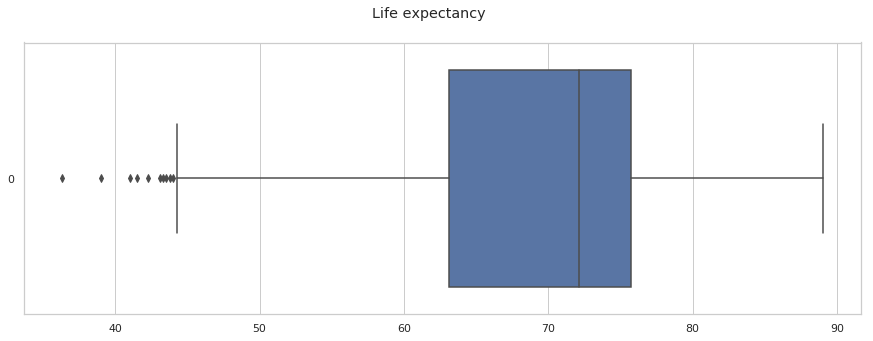

In [250]:
quick_boxplot(life_df['Life expectancy'],'Life expectancy',logscale=False)

In [251]:
life_df.loc[life_df['Life expectancy'] < 40][['Country','Year','Life expectancy']]

,Country,Year,Life expectancy
1128,Haiti,2010,36.3
2313,Sierra Leone,2000,39.0


The distribution is not normal:

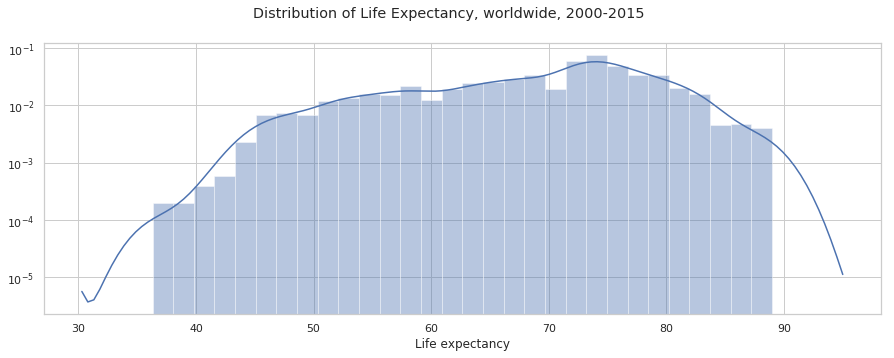

In [252]:
quick_distplot(life_df['Life expectancy'],"Distribution of Life Expectancy, worldwide, 2000-2015")

### Adult mortality

These numbers are mostly reasonable, being the probability of dying between ages 15 and 60, per 1000 population. I'd expect to see numbers 0-1000 and at least that is true. I do see some minor outliers--instances where a country has a really low number for just one year (Afghanistan, 2002; Zimbabwe, 2006, when Zimbabwe has the three highest values in the preceding years 2003-2005).

We could winsorize these values by country to reduce the chances of an outlier affecting later analysis.

In [253]:
life_df[['Country','Adult mortality']].sort_values('Adult mortality')

,Country,Adult mortality
1468,Lebanon,1.0
210,Barbados,1.0
929,Finland,1.0
2243,Saudi Arabia,1.0
377,Brunei Darussalam,1.0
255,Belgium,1.0
330,Bosnia and Herzegovina,1.0
23,Albania,1.0
2665,Tunisia,1.0
637,Costa Rica,1.0


In [254]:
mean_mortality_rate = life_df[['Country','Adult mortality']].groupby('Country').mean().sort_values('Adult mortality')
#mmr_low
mean_mortality_rate

,Adult mortality
Country,
Tunisia,18.7500
Albania,45.0625
Iceland,49.3750
Saudi Arabia,52.1250
Cyprus,54.1250
Italy,54.1875
Switzerland,55.7500
Japan,57.1250
Cuba,57.5625


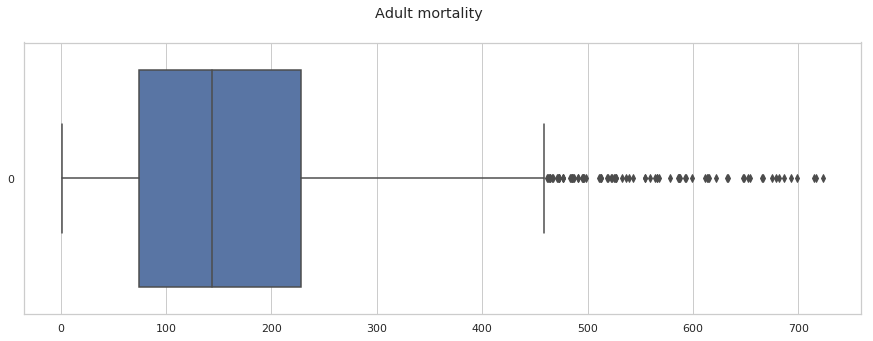

In [255]:
quick_boxplot(life_df['Adult mortality'],"Adult mortality",logscale=False)

# START HERE.
## You are thinking about a decent way to automate outlier detection, using either zscore or Tukey's method, and then apply it per country to eliminate outliers.
### Recall that Tunisia had an outlier at either end of its range (1, 11...12, 112), so unfortunately you can't just test for outliers at one end. :(
### Saudi Arabia is also a weird case, having roughly half of its values in the teens, and half in the 90s

# ORRRRRRR, because this find_outliers function doesn't detect any problems with Saudi Arabia when there clearly is one, maybe we grab the records where adult mortality is in the single digits, see how that compares to the mean for that country, and complain if they are far apart. 

^^^So look at the standard deviation and complain if it seems high. But what is "high"?

In [259]:
adult_mortality_outliers = find_outliers(life_df,'Country','Adult mortality',return_outliers=True)

Country: Afghanistan: Found 1 outliers at threshold == 5.0: [155.5, 411.25, 1]
{1.0: [248.5, 318.25, 2], 1.5: [236.875, 329.875, 1], 2.0: [225.25, 341.5, 1], 2.5: [213.625, 353.125, 1], 3.0: [202.0, 364.75, 1], 3.5: [190.375, 376.375, 1], 4.0: [178.75, 388.0, 1], 4.5: [167.125, 399.625, 1], 5.0: [155.5, 411.25, 1]}
Country: Albania: Found 0 outliers at threshold == 1.0: [-60.0, 159.75, 0]
Country: Algeria: Found 0 outliers at threshold == 4.0: [10.75, 240.25, 0]
{1.0: [87.25, 163.75, 3], 1.5: [74.5, 176.5, 3], 2.0: [61.75, 189.25, 3], 2.5: [49.0, 202.0, 3], 3.0: [36.25, 214.75, 3], 3.5: [23.5, 227.5, 3], 4.0: [10.75, 240.25, 0], 4.5: [-2.0, 253.0, 0], 5.0: [-14.75, 265.75, 0]}
Country: Côte d'Ivoire: Found 1 outliers at threshold == 5.0: [167.75, 715.0, 1]
{1.0: [366.75, 516.0, 1], 1.5: [341.875, 540.875, 1], 2.0: [317.0, 565.75, 1], 2.5: [292.125, 590.625, 1], 3.0: [267.25, 615.5, 1], 3.5: [242.375, 640.375, 1], 4.0: [217.5, 665.25, 1], 4.5: [192.625, 690.125, 1], 5.0: [167.75, 715.0,

Country: Czechia: Found 0 outliers at threshold == 1.0: [-81.0, 212.25, 0]
Country: Democratic People's Republic of Korea: Found 0 outliers at threshold == 2.5: [118.875, 198.375, 0]
{1.0: [138.75, 178.5, 1], 1.5: [132.125, 185.125, 1], 2.0: [125.5, 191.75, 1], 2.5: [118.875, 198.375, 0], 3.0: [112.25, 205.0, 0], 3.5: [105.625, 211.625, 0], 4.0: [99.0, 218.25, 0], 4.5: [92.375, 224.875, 0], 5.0: [85.75, 231.5, 0]}
Country: Democratic Republic of the Congo: Found 2 outliers at threshold == 5.0: [41.75, 545.0, 2]
{1.0: [224.75, 362.0, 2], 1.5: [201.875, 384.875, 2], 2.0: [179.0, 407.75, 2], 2.5: [156.125, 430.625, 2], 3.0: [133.25, 453.5, 2], 3.5: [110.375, 476.375, 2], 4.0: [87.5, 499.25, 2], 4.5: [64.625, 522.125, 2], 5.0: [41.75, 545.0, 2]}
Country: Denmark: Found 0 outliers at threshold == 1.5: [8.375, 137.375, 0]
{1.0: [24.5, 121.25, 4], 1.5: [8.375, 137.375, 0], 2.0: [-7.75, 153.5, 0], 2.5: [-23.875, 169.625, 0], 3.0: [-40.0, 185.75, 0], 3.5: [-56.125, 201.875, 0], 4.0: [-72.25, 21

Country: Lesotho: Found 0 outliers at threshold == 4.5: [0.125, 1157.625, 0]
{1.0: [405.25, 752.5, 1], 1.5: [347.375, 810.375, 1], 2.0: [289.5, 868.25, 1], 2.5: [231.625, 926.125, 1], 3.0: [173.75, 984.0, 1], 3.5: [115.875, 1041.875, 1], 4.0: [58.0, 1099.75, 1], 4.5: [0.125, 1157.625, 0], 5.0: [-57.75, 1215.5, 0]}
Country: Liberia: Found 0 outliers at threshold == 4.0: [16.75, 561.25, 0]
{1.0: [198.25, 379.75, 3], 1.5: [168.0, 410.0, 3], 2.0: [137.75, 440.25, 3], 2.5: [107.5, 470.5, 3], 3.0: [77.25, 500.75, 3], 3.5: [47.0, 531.0, 3], 4.0: [16.75, 561.25, 0], 4.5: [-13.5, 591.5, 0], 5.0: [-43.75, 621.75, 0]}
Country: Libya: Found 0 outliers at threshold == 1.5: [115.125, 162.125, 0]
{1.0: [121.0, 156.25, 1], 1.5: [115.125, 162.125, 0], 2.0: [109.25, 168.0, 0], 2.5: [103.375, 173.875, 0], 3.0: [97.5, 179.75, 0], 3.5: [91.625, 185.625, 0], 4.0: [85.75, 191.5, 0], 4.5: [79.875, 197.375, 0], 5.0: [74.0, 203.25, 0]}
Country: Lithuania: Found 0 outliers at threshold == 1.0: [-145.0, 356.0, 0]

Country: Sierra Leone: Found 0 outliers at threshold == 2.0: [23.5, 771.0, 0]
{1.0: [173.0, 621.5, 4], 1.5: [98.25, 696.25, 4], 2.0: [23.5, 771.0, 0], 2.5: [-51.25, 845.75, 0], 3.0: [-126.0, 920.5, 0], 3.5: [-200.75, 995.25, 0], 4.0: [-275.5, 1070.0, 0], 4.5: [-350.25, 1144.75, 0], 5.0: [-425.0, 1219.5, 0]}
Country: Singapore: Found 0 outliers at threshold == 4.5: [0.0, 130.0, 0]
{1.0: [45.5, 84.5, 1], 1.5: [39.0, 91.0, 1], 2.0: [32.5, 97.5, 1], 2.5: [26.0, 104.0, 1], 3.0: [19.5, 110.5, 1], 3.5: [13.0, 117.0, 1], 4.0: [6.5, 123.5, 1], 4.5: [0.0, 130.0, 0], 5.0: [-6.5, 136.5, 0]}
Country: Slovenia: Found 0 outliers at threshold == 1.0: [5.5, 168.25, 0]
Country: Solomon Islands: Found 0 outliers at threshold == 1.0: [-136.75, 356.75, 0]
Country: Somalia: Found 1 outliers at threshold == 5.0: [253.25, 415.5, 1]
{1.0: [312.25, 356.5, 2], 1.5: [304.875, 363.875, 1], 2.0: [297.5, 371.25, 1], 2.5: [290.125, 378.625, 1], 3.0: [282.75, 386.0, 1], 3.5: [275.375, 393.375, 1], 4.0: [268.0, 400.75,

In [260]:
adult_mortality_outliers

['Afghanistan',
 'Algeria',
 "Côte d'Ivoire",
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Belarus',
 'Belgium',
 'Belize',
 'Bhutan',
 'Bolivia (Plurinational State of)',
 'Brazil',
 'Brunei Darussalam',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'China',
 'Colombia',
 'Comoros',
 'Congo',
 'Croatia',
 'Cyprus',
 "Democratic People's Republic of Korea",
 'Democratic Republic of the Congo',
 'Denmark',
 'Djibouti',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Slovakia',
 'Equatorial Guinea',
 'Eritrea',
 'Ethiopia',
 'Finland',
 'France',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Greece',
 'Grenada',
 'Guinea',
 'Guyana',
 'Haiti',
 'Honduras',
 'Hungary',
 'Iceland',
 'Indonesia',
 'Iran (Islamic Republic of)',
 'Iraq',
 'Ireland',
 'Israel',
 'Italy',
 'Jamaica',
 'Japan',
 'Jordan',
 'Kazakhstan',
 'Kuwait',
 'Ky

In [261]:
life_df.loc[life_df['Country'] == 'Saudi Arabia','Adult mortality']
#life_df.loc[life_df['Adult mortality'] == 1]

2234    88.0
2235    88.0
2236    89.0
2237     9.0
2238    92.0
2239    94.0
2240    97.0
2241    98.0
2242    99.0
2243     1.0
2244    11.0
2245    12.0
2246    13.0
2247    15.0
2248    17.0
2249    11.0
Name: Adult mortality, dtype: float64

In [262]:
tunisia_zscore = get_zscore(life_df.loc[life_df['Country'] == 'Saudi Arabia'],'Adult mortality')
tunisia_zscore

The score threshold is: 1
The indices of the outliers:
(array([5, 6, 7, 8]),)
Number of outliers is: 4
The score threshold is: 2
The indices of the outliers:
(array([], dtype=int64),)
Number of outliers is: 0
The score threshold is: 3
The indices of the outliers:
(array([], dtype=int64),)
Number of outliers is: 0
The score threshold is: 4
The indices of the outliers:
(array([], dtype=int64),)
Number of outliers is: 0


{1: (array([5, 6, 7, 8]),),
 2: (array([], dtype=int64),),
 3: (array([], dtype=int64),),
 4: (array([], dtype=int64),)}

In [263]:
life_df.loc[life_df['Country'] == 'Tunisia',['Country','Year','Adult mortality']].sort_values('Adult mortality')

,Country,Year,Adult mortality
2665,Tunisia,2015,1.0
2679,Tunisia,2001,11.0
2666,Tunisia,2014,12.0
2670,Tunisia,2010,12.0
2671,Tunisia,2009,12.0
2672,Tunisia,2008,12.0
2673,Tunisia,2007,12.0
2674,Tunisia,2006,12.0
2667,Tunisia,2013,13.0
2668,Tunisia,2012,13.0


In [264]:
life_df.loc[life_df['Country'] == 'Tunisia', 'Adult mortality'] = winsorize(life_df.loc[life_df['Country'] == 'Tunisia']['Adult mortality'], (0.10, .90))

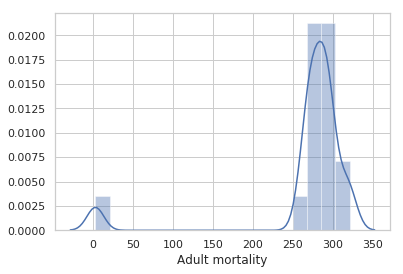

In [265]:
sns.distplot(life_df.loc[life_df['Country'] == 'Afghanistan']['Adult mortality'])

In [266]:
life_df.loc[life_df['Country'] == 'Afghanistan']['Adult mortality']

0     263.0
1     271.0
2     268.0
3     272.0
4     275.0
5     279.0
6     281.0
7     287.0
8     295.0
9     295.0
10    291.0
11    293.0
12    295.0
13      3.0
14    316.0
15    321.0
Name: Adult mortality, dtype: float64

In [267]:
life_df.loc[life_df['Country'] == 'Afghanistan', 'Adult mortality'] = winsorize(life_df.loc[life_df['Country'] == 'Afghanistan']['Adult mortality'], (0.10, 0))

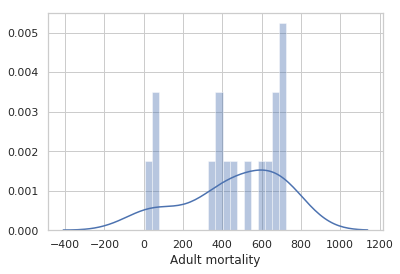

In [268]:
sns.distplot(life_df.loc[life_df['Country'] == 'Zimbabwe']['Adult mortality'],bins=20)

In [269]:
life_df.loc[life_df['Country'] == 'Zimbabwe']['Adult mortality']

2922    336.0
2923    371.0
2924    399.0
2925    429.0
2926    464.0
2927    527.0
2928    587.0
2929    632.0
2930     67.0
2931      7.0
2932    717.0
2933    723.0
2934    715.0
2935     73.0
2936    686.0
2937    665.0
Name: Adult mortality, dtype: float64

In [270]:
# Tweaked the lower limit until the outliers took on the values of the minimum of the "real" range
life_df.loc[life_df['Country'] == 'Zimbabwe', 'Adult mortality'] = winsorize(life_df.loc[life_df['Country'] == 'Zimbabwe']['Adult mortality'], (0.20, 0))

## Infant deaths

This is infant deaths per 1000 population. There are a lot of outliers for this variable that are > 1000, and those don't make sense. The worldwide mean on [The World Bank's site]() ranges from 53 in 2000 to 31 in 2015. Each country has its own unique rates, but the overall trend is linear, decreasing over time. 

All of India's values are over 900, with most over 1000. [The World Bank](https://data.worldbank.org/indicator/SP.DYN.IMRT.IN?locations=IN) suggests a range more like 66.7 - 35.3 deaths per 1000 population between 2000 and 2015. We can divide the values in the dataset by 27 to get numbers that are closer to the actual rates.

Nigeria's values here are also really high, suggesting over 500 infants minimum per 1000 population die. Again, [The World Bank](https://data.worldbank.org/indicator/SP.DYN.IMRT.IN?end=2015&locations=NG&start=2000) suggests a much lower rate, 111.6 - 68.7 between 2000 and 2015. We can divide by 5-6 to get these lower values.

China's rates are somewhere between 30.1 - 9.2, according to [The World Bank](https://data.worldbank.org/indicator/SP.DYN.IMRT.IN?end=2015&locations=CN&start=2000). Its values of 490 - 157 are off by a factor of about 16-17.

Pakistan's rates should be between 87.9 - 64, but are 385 - 352. We can divide by about 4.6 to get something reasonably close to [their World Bank-reported rates](https://data.worldbank.org/indicator/SP.DYN.IMRT.IN?end=2015&locations=PK&start=2000).

The Democratic Republic of the Congo's numbers are also high--226 - 236, instead of 107 - 74. It's also weird that their 2015 number is higher than their 2000 number, when infant death rates consistently drop over time everywhere else. But we can divide by about 2.6 to get to reasonably close values.

Indonesia's numbers are 187 - 114, instead of 40 - 22--4.8 times higher.

Bangladesh's numbers are 231 - 104, instead of 64 - 29--3.6 times higher.

Ethiopa's numbers are 253 - 225, instead of 88 - 44--an average of 3.95 times higher.

There are a lot of countries that have all zeroes, when it would be a miracle if that were true. We can use the worldwide means to fill in numbers.

Some countries have zeroes for half or fewer of their range of years. I was ready to interpolate to fill in the non-zero values, until I noticed that in all of these cases, the non-zero values were all ones. So I also overwrote the values for these countries with the worldwide means.

In [271]:
life_df.loc[life_df['Country'] == 'China','Infant deaths'] = life_df.loc[life_df['Country'] == 'China','Infant deaths'] / 16.5

In [272]:
life_df.loc[life_df['Country'] == 'India','Infant deaths'] = life_df.loc[life_df['Country'] == 'India','Infant deaths'] / 27

In [273]:
life_df.loc[life_df['Country'] == 'Nigeria','Infant deaths'] = life_df.loc[life_df['Country'] == 'Nigeria','Infant deaths'] / 5.5

In [274]:
life_df.loc[life_df['Country'] == 'Pakistan','Infant deaths'] = life_df.loc[life_df['Country'] == 'Pakistan','Infant deaths'] / 4.6

In [275]:
life_df.loc[life_df['Country'] == 'Democratic Republic of the Congo','Infant deaths'] = life_df.loc[life_df['Country'] == 'Democratic Republic of the Congo','Infant deaths'] / 2.6

In [276]:
life_df.loc[life_df['Country'] == 'Indonesia','Infant deaths'] = life_df.loc[life_df['Country'] == 'Indonesia','Infant deaths'] / 4.8

In [277]:
life_df.loc[life_df['Country'] == 'Bangladesh','Infant deaths'] = life_df.loc[life_df['Country'] == 'Bangladesh','Infant deaths'] / 3.6

In [278]:
life_df.loc[life_df['Country'] == 'Ethiopia','Infant deaths'] = life_df.loc[life_df['Country'] == 'Ethiopia','Infant deaths'] / 3.95

In [279]:
life_df.loc[life_df['Infant deaths'] < 10]

,Country,Year,Status,Life expectancy,Adult mortality,Infant deaths,Alcohol,Percentage expenditure,Hepatitis b,Measles,...,Polio,Total expenditure,Diphtheria,Hiv/aids,Gdp,Population,Thinness 1-19 years,Thinness 5-9 years,Income composition of resources,Schooling
16,Albania,2015,Developing,77.8,74.0,0.0,4.60,364.975229,99.0,0,...,99.0,6.00,99.0,0.1,3954.227830,28873.0,1.2,1.3,0.762,14.2
17,Albania,2014,Developing,77.5,8.0,0.0,4.51,428.749067,98.0,0,...,98.0,5.88,98.0,0.1,4575.763787,288914.0,1.2,1.3,0.761,14.2
18,Albania,2013,Developing,77.2,84.0,0.0,4.76,430.876979,99.0,0,...,99.0,5.66,99.0,0.1,4414.723140,289592.0,1.3,1.4,0.759,14.2
19,Albania,2012,Developing,76.9,86.0,0.0,5.14,412.443356,99.0,9,...,99.0,5.59,99.0,0.1,4247.614380,2941.0,1.3,1.4,0.752,14.2
20,Albania,2011,Developing,76.6,88.0,0.0,5.37,437.062100,99.0,28,...,99.0,5.71,99.0,0.1,4437.178680,295195.0,1.4,1.5,0.738,13.3
21,Albania,2010,Developing,76.2,91.0,1.0,5.28,41.822757,99.0,10,...,99.0,5.34,99.0,0.1,494.358832,291321.0,1.4,1.5,0.725,12.5
22,Albania,2009,Developing,76.1,91.0,1.0,5.79,348.055952,98.0,0,...,98.0,5.79,98.0,0.1,4114.136545,2927519.0,1.5,1.6,0.721,12.2
23,Albania,2008,Developing,75.3,1.0,1.0,5.61,36.622068,99.0,0,...,99.0,5.87,99.0,0.1,437.539647,2947314.0,1.6,1.6,0.713,12.0
24,Albania,2007,Developing,75.9,9.0,1.0,5.58,32.246552,98.0,22,...,99.0,6.10,98.0,0.1,363.136850,29717.0,1.6,1.7,0.703,11.6
25,Albania,2006,Developing,74.2,99.0,1.0,5.31,3.302154,98.0,68,...,97.0,5.86,97.0,0.1,35.129300,2992547.0,1.7,1.8,0.696,11.4


In [280]:
zero_infant_deaths = life_df.loc[life_df['Infant deaths'] == 0,'Country'].value_counts().to_frame()
zero_infant_deaths

,Country
Latvia,16
Cyprus,16
Finland,16
Antigua and Barbuda,16
Grenada,16
The former Yugoslav republic of Macedonia,16
Montenegro,16
Vanuatu,16
Mauritius,16
Denmark,16


In [281]:
zid_missing = zero_infant_deaths.loc[zero_infant_deaths['Country'] == 16]
zid_partial = zero_infant_deaths.loc[zero_infant_deaths['Country'] < 16]
zid_partial

,Country
Portugal,13
Greece,13
Belgium,12
Kuwait,8
Uruguay,7
Hungary,7
Guyana,7
Belarus,7
Bhutan,5
Albania,5


I've since noticed that even though some of these countries have non-zero values, those values are all ones, which are not realistic. So I'm overwriting the values for all of these countries with the world mean values.

In [282]:
infant_worldwide_mean = pd.DataFrame({'Year': [2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015]})
infant_worldwide_mean.at[0,'Infant deaths'] = 53.6
infant_worldwide_mean.at[15,'Infant deaths'] = 31.2
infant_worldwide_mean.interpolate(limit_direction='forward',inplace=True)
infant_worldwide_mean

,Year,Infant deaths
0,2000,53.600000
1,2001,52.106667
2,2002,50.613333
3,2003,49.120000
4,2004,47.626667
5,2005,46.133333
6,2006,44.640000
7,2007,43.146667
8,2008,41.653333
9,2009,40.160000


In [283]:
for this_country in zero_infant_deaths.index:
    for this_year in infant_worldwide_mean['Year']:
        upd_index = int(life_df.loc[(life_df['Country'] == this_country) & (life_df['Year'] == this_year)].index[0])
        print("Updating value for {}, {}. Index {}".format(this_country,this_year,upd_index))
        life_df.at[upd_index,'Infant deaths'] = \
          infant_worldwide_mean.loc[infant_worldwide_mean['Year'] == this_year]['Infant deaths']
    

Updating value for Latvia, 2000. Index 1458
Updating value for Latvia, 2001. Index 1457
Updating value for Latvia, 2002. Index 1456
Updating value for Latvia, 2003. Index 1455
Updating value for Latvia, 2004. Index 1454
Updating value for Latvia, 2005. Index 1453
Updating value for Latvia, 2006. Index 1452
Updating value for Latvia, 2007. Index 1451
Updating value for Latvia, 2008. Index 1450
Updating value for Latvia, 2009. Index 1449
Updating value for Latvia, 2010. Index 1448
Updating value for Latvia, 2011. Index 1447
Updating value for Latvia, 2012. Index 1446
Updating value for Latvia, 2013. Index 1445
Updating value for Latvia, 2014. Index 1444
Updating value for Latvia, 2015. Index 1443
Updating value for Cyprus, 2000. Index 688
Updating value for Cyprus, 2001. Index 687
Updating value for Cyprus, 2002. Index 686
Updating value for Cyprus, 2003. Index 685
Updating value for Cyprus, 2004. Index 684
Updating value for Cyprus, 2005. Index 683
Updating value for Cyprus, 2006. Index

Updating value for Fiji, 2011. Index 903
Updating value for Fiji, 2012. Index 902
Updating value for Fiji, 2013. Index 901
Updating value for Fiji, 2014. Index 900
Updating value for Fiji, 2015. Index 899
Updating value for Sweden, 2000. Index 2520
Updating value for Sweden, 2001. Index 2519
Updating value for Sweden, 2002. Index 2518
Updating value for Sweden, 2003. Index 2517
Updating value for Sweden, 2004. Index 2516
Updating value for Sweden, 2005. Index 2515
Updating value for Sweden, 2006. Index 2514
Updating value for Sweden, 2007. Index 2513
Updating value for Sweden, 2008. Index 2512
Updating value for Sweden, 2009. Index 2511
Updating value for Sweden, 2010. Index 2510
Updating value for Sweden, 2011. Index 2509
Updating value for Sweden, 2012. Index 2508
Updating value for Sweden, 2013. Index 2507
Updating value for Sweden, 2014. Index 2506
Updating value for Sweden, 2015. Index 2505
Updating value for Saint Vincent and the Grenadines, 2000. Index 2200
Updating value for Sa

Updating value for Maldives, 2010. Index 1608
Updating value for Maldives, 2011. Index 1607
Updating value for Maldives, 2012. Index 1606
Updating value for Maldives, 2013. Index 1605
Updating value for Maldives, 2014. Index 1604
Updating value for Maldives, 2015. Index 1603
Updating value for Slovenia, 2000. Index 2360
Updating value for Slovenia, 2001. Index 2359
Updating value for Slovenia, 2002. Index 2358
Updating value for Slovenia, 2003. Index 2357
Updating value for Slovenia, 2004. Index 2356
Updating value for Slovenia, 2005. Index 2355
Updating value for Slovenia, 2006. Index 2354
Updating value for Slovenia, 2007. Index 2353
Updating value for Slovenia, 2008. Index 2352
Updating value for Slovenia, 2009. Index 2351
Updating value for Slovenia, 2010. Index 2350
Updating value for Slovenia, 2011. Index 2349
Updating value for Slovenia, 2012. Index 2348
Updating value for Slovenia, 2013. Index 2347
Updating value for Slovenia, 2014. Index 2346
Updating value for Slovenia, 2015.

Updating value for Cabo Verde, 2012. Index 451
Updating value for Cabo Verde, 2013. Index 450
Updating value for Cabo Verde, 2014. Index 449
Updating value for Cabo Verde, 2015. Index 448
Updating value for Lithuania, 2000. Index 1538
Updating value for Lithuania, 2001. Index 1537
Updating value for Lithuania, 2002. Index 1536
Updating value for Lithuania, 2003. Index 1535
Updating value for Lithuania, 2004. Index 1534
Updating value for Lithuania, 2005. Index 1533
Updating value for Lithuania, 2006. Index 1532
Updating value for Lithuania, 2007. Index 1531
Updating value for Lithuania, 2008. Index 1530
Updating value for Lithuania, 2009. Index 1529
Updating value for Lithuania, 2010. Index 1528
Updating value for Lithuania, 2011. Index 1527
Updating value for Lithuania, 2012. Index 1526
Updating value for Lithuania, 2013. Index 1525
Updating value for Lithuania, 2014. Index 1524
Updating value for Lithuania, 2015. Index 1523
Updating value for Brunei Darussalam, 2000. Index 384
Updati

Updating value for Portugal, 2008. Index 2063
Updating value for Portugal, 2009. Index 2062
Updating value for Portugal, 2010. Index 2061
Updating value for Portugal, 2011. Index 2060
Updating value for Portugal, 2012. Index 2059
Updating value for Portugal, 2013. Index 2058
Updating value for Portugal, 2014. Index 2057
Updating value for Portugal, 2015. Index 2056
Updating value for Greece, 2000. Index 1042
Updating value for Greece, 2001. Index 1041
Updating value for Greece, 2002. Index 1040
Updating value for Greece, 2003. Index 1039
Updating value for Greece, 2004. Index 1038
Updating value for Greece, 2005. Index 1037
Updating value for Greece, 2006. Index 1036
Updating value for Greece, 2007. Index 1035
Updating value for Greece, 2008. Index 1034
Updating value for Greece, 2009. Index 1033
Updating value for Greece, 2010. Index 1032
Updating value for Greece, 2011. Index 1031
Updating value for Greece, 2012. Index 1030
Updating value for Greece, 2013. Index 1029
Updating value f

In [284]:
life_df['Infant deaths'].describe()

count    2928.000000
mean       28.552218
std        23.188259
min         1.000000
25%         5.000000
50%        31.000000
75%        44.640000
max       116.000000
Name: Infant deaths, dtype: float64

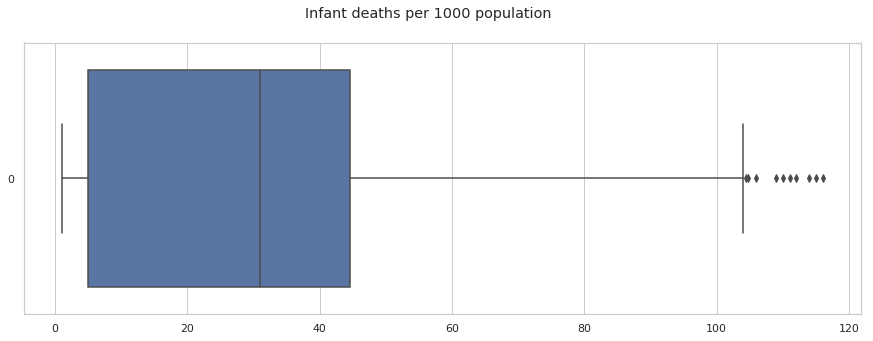

In [285]:
quick_boxplot(life_df['Infant deaths'],"Infant deaths per 1000 population",logscale=False)

## Alcohol consumption

No outliers here. There are a lot of countries with low numbers--at a glance, a lot of them are countries who likely have strict laws against consumption based on religious reasons (Middle Eastern countries for instance). I'm going to roll with these numbers.

In [286]:
life_df.loc[life_df['Alcohol'] < 1]['Country'].unique()

array(['Afghanistan', 'Algeria', 'Azerbaijan', 'Bangladesh', 'Benin',
       'Bhutan', 'Botswana', 'Brunei Darussalam', 'Burkina Faso',
       'Burundi', "Côte d'Ivoire", 'Cabo Verde', 'Cambodia', 'Cameroon',
       'Central African Republic', 'Chad', 'Comoros', 'Congo', 'Cyprus',
       "Democratic People's Republic of Korea",
       'Democratic Republic of the Congo', 'Djibouti', 'Egypt',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Fiji',
       'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Haiti',
       'Hungary', 'India', 'Indonesia', 'Iran (Islamic Republic of)',
       'Iraq', 'Japan', 'Jordan', 'Kenya', 'Kiribati', 'Kuwait',
       'Kyrgyzstan', "Lao People's Democratic Republic", 'Latvia',
       'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Malaysia',
       'Maldives', 'Mali', 'Mauritania', 'Mauritius', 'Mongolia',
       'Montenegro', 'Morocco', 'Mozambique', 'Myanmar', 'Namibia',
       'Nepal', 'Netherlands', 'Niger', 'Nigeria', 'Oma

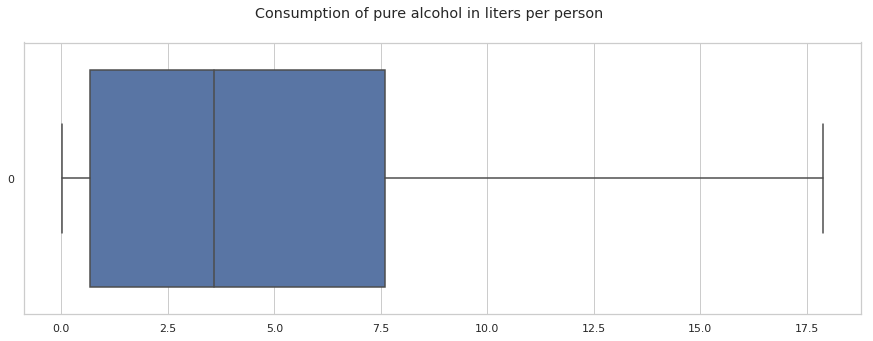

In [287]:
quick_boxplot(life_df['Alcohol'],"Consumption of pure alcohol in liters per person",logscale=False)

## Percentage expenditure on health as a percentage of GDP per capita

This number is a percentage--so unless a country is spending exorbitant amounts on health care, a range 0-100% should cover all reasonable values.

There are a number of LARGE outliers here--large enough to make me wonder if they represent actual amounts of money spent on health and not just a percentage of GDP.

There are also a lot of zeroes here--Zimbabwe, for instance, does not spend a lot [based on what I see on the WHO website](https://www.who.int/countries/zwe/en/), but they spend more than 0% of GDP per capita. We'll have to address these as well.

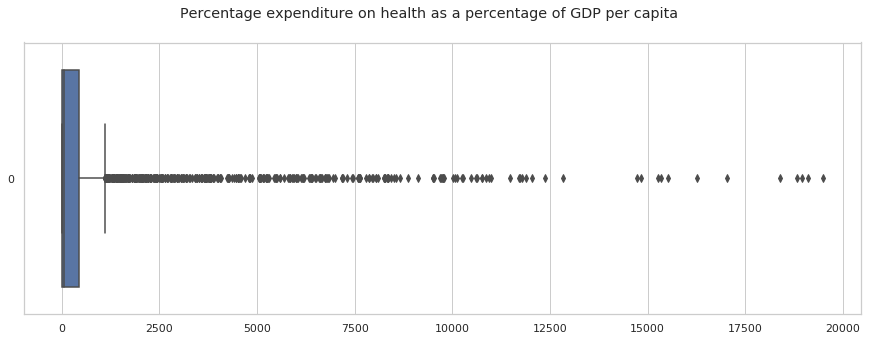

In [288]:
quick_boxplot(life_df['Percentage expenditure'],"Percentage expenditure on health as a percentage of GDP per capita",logscale=False)

In [289]:
life_df['Percentage expenditure'].describe()

count     2928.000000
mean       740.321185
std       1990.930605
min          0.000000
25%          4.853964
50%         65.611455
75%        442.614322
max      19479.911610
Name: Percentage expenditure, dtype: float64

In [290]:
life_df.loc[life_df['Percentage expenditure'] < 100,['Country','Year','Percentage expenditure']]

,Country,Year,Percentage expenditure
0,Afghanistan,2015,71.279624
1,Afghanistan,2014,73.523582
2,Afghanistan,2013,73.219243
3,Afghanistan,2012,78.184215
4,Afghanistan,2011,7.097109
5,Afghanistan,2010,79.679367
6,Afghanistan,2009,56.762217
7,Afghanistan,2008,25.873925
8,Afghanistan,2007,10.910156
9,Afghanistan,2006,17.171518


## Hepatitis B immunization rates for 1-year olds

I dealt with this variable when I found values to fill in above. It is also a percentage, and the outliers here make sense--I assigned Japan its zeroes for instance, because they did not even have a program for immunization against Hepatitis B until 2016.

In [291]:
life_df['Hepatitis b'].describe()

count    2928.000000
mean       75.447080
std        28.616318
min         0.000000
25%        66.000000
50%        88.000000
75%        96.000000
max        99.000000
Name: Hepatitis b, dtype: float64

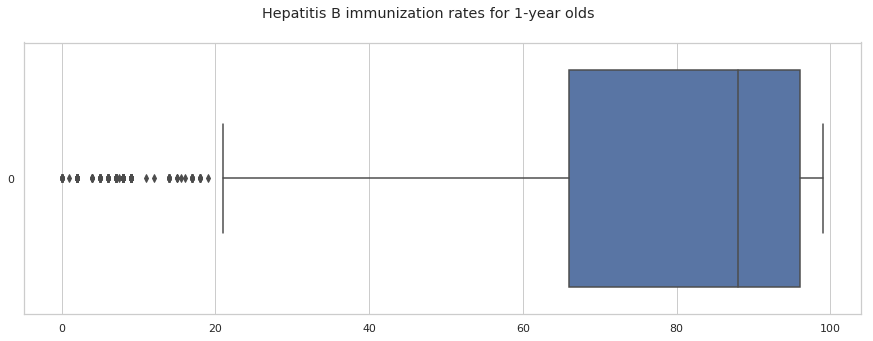

In [292]:
quick_boxplot(life_df['Hepatitis b'],"Hepatitis B immunization rates for 1-year olds",logscale=False)

## Measles

This is the number of cases reported per 1000 population, so at a max, values 0-1000 make sense. I see a lot of outliers here as well unfortunately.

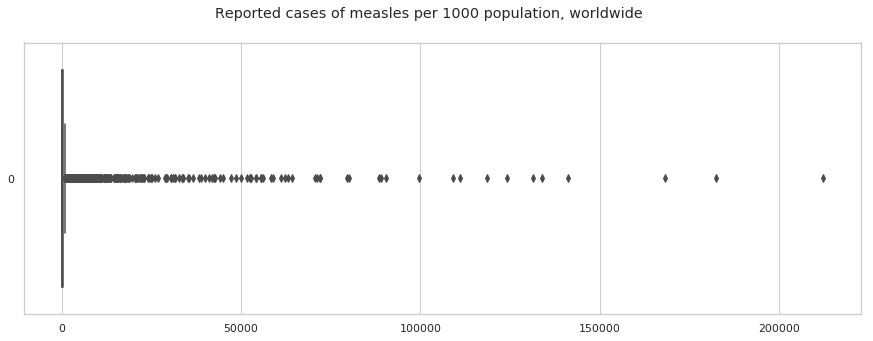

In [293]:
quick_boxplot(life_df['Measles'],"Reported cases of measles per 1000 population, worldwide",logscale=False)

In [294]:
life_df['Measles'].describe()

count      2928.000000
mean       2427.855874
std       11485.970937
min           0.000000
25%           0.000000
50%          17.000000
75%         362.250000
max      212183.000000
Name: Measles, dtype: float64

In [295]:
life_df.loc[life_df['Measles'] > 1000]['Country'].unique() #,['Country','Year','Measles']]

array(['Afghanistan', "Côte d'Ivoire", 'Algeria', 'Angola', 'Armenia',
       'Azerbaijan', 'Bangladesh', 'Benin', 'Bosnia and Herzegovina',
       'Botswana', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia',
       'Cameroon', 'Central African Republic', 'Chad', 'China', 'Congo',
       "Democratic People's Republic of Korea",
       'Democratic Republic of the Congo', 'Egypt', 'Equatorial Guinea',
       'Ethiopia', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana',
       'Guinea', 'Guinea-Bissau', 'India', 'Indonesia',
       'Iran (Islamic Republic of)', 'Iraq', 'Italy', 'Japan',
       'Kazakhstan', 'Kenya', 'Kyrgyzstan',
       "Lao People's Democratic Republic", 'Lebanon', 'Lesotho',
       'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives',
       'Mali', 'Mauritania', 'Mongolia', 'Morocco', 'Mozambique',
       'Myanmar', 'Namibia', 'Nepal', 'Netherlands', 'Niger', 'Nigeria',
       'Pakistan', 'Papua New Guinea', 'Philippines', 'Republic of Korea',
       'R

In [296]:
life_df.loc[life_df['Measles'] > 10000].sort_values(['Measles'],ascending=False)

,Country,Year,Status,Life expectancy,Adult mortality,Infant deaths,Alcohol,Percentage expenditure,Hepatitis b,Measles,...,Polio,Total expenditure,Diphtheria,Hiv/aids,Gdp,Population,Thinness 1-19 years,Thinness 5-9 years,Income composition of resources,Schooling
1909,Nigeria,2000,Developing,47.1,45.0,104.727273,9.23,22.481776,18.0,212183,...,31.0,2.8400,29.0,4.9,379.119326,1.223529e+06,14.3,14.4,0.000,7.60000
731,Democratic Republic of the Congo,2005,Developing,54.3,314.0,89.615385,1.43,0.000000,7.0,182485,...,6.0,3.1400,6.0,2.0,218.386191,5.478590e+07,11.5,11.3,0.457,5.97002
1908,Nigeria,2001,Developing,47.4,48.0,104.363636,9.58,15.830985,18.0,168107,...,36.0,3.2500,27.0,5.1,351.799667,1.254634e+08,14.1,14.1,0.000,8.00000
1906,Nigeria,2003,Developing,48.1,41.0,103.090909,9.75,30.195508,18.0,141258,...,42.0,4.5000,29.0,5.4,512.657190,1.319725e+08,13.5,13.6,0.000,8.10000
725,Democratic Republic of the Congo,2011,Developing,57.9,278.0,91.923077,1.82,0.000000,74.0,133802,...,77.0,3.5300,74.0,1.6,387.082465,6.675515e+07,1.2,1.0,0.457,5.97002
567,China,2008,Developing,74.5,97.0,16.121212,4.27,39.225097,95.0,131441,...,99.0,4.5900,97.0,0.1,3471.247547,1.324655e+06,4.5,4.0,0.672,11.90000
570,China,2005,Developing,73.9,99.0,20.121212,2.92,171.659603,84.0,124219,...,87.0,4.6600,87.0,0.1,1753.417800,1.337200e+04,5.0,4.4,0.634,10.60000
1576,Malawi,2010,Developing,52.9,462.0,35.000000,1.08,9.728005,93.0,118712,...,86.0,1.5000,93.0,13.7,458.868174,1.516795e+06,6.8,6.7,0.430,10.20000
1904,Nigeria,2005,Developing,49.2,4.0,101.090909,9.71,6.416253,18.0,110927,...,45.0,4.1100,36.0,5.4,87.893874,1.389395e+08,12.9,12.9,0.463,8.90000
568,China,2007,Developing,74.4,96.0,17.272727,3.88,312.662482,92.0,109023,...,94.0,4.3200,93.0,0.1,2695.366223,1.317885e+06,4.7,4.1,0.659,11.40000


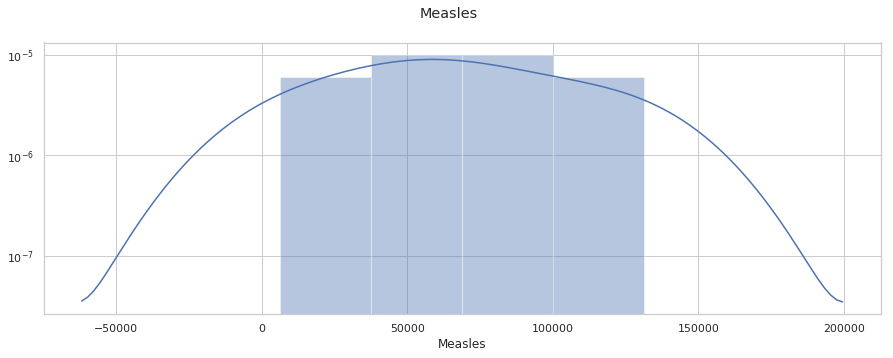

In [297]:
quick_distplot(life_df.loc[life_df['Country'] == 'China']['Measles'],"Measles")

## BMI

Average BMI of an entire country's population. Values under 15 or over 50 are probably outliers (this is already a pretty broad range for BMI, which should be in the 20s on average).

[WHO data from 2015 (as reported on this Wikipedia page)](https://en.wikipedia.org/wiki/List_of_countries_by_body_mass_index) suggests the country with the highest overall mean BMI should be Nauru, with 32.5. Samoa should rank third with 31.7. Samoa's values in this dataset are over twice this number.

In [298]:
life_df['Bmi'].describe()

count    2926.000000
mean       38.019481
std        19.972738
min         1.000000
25%        19.100000
50%        43.000000
75%        56.100000
max        77.600000
Name: Bmi, dtype: float64

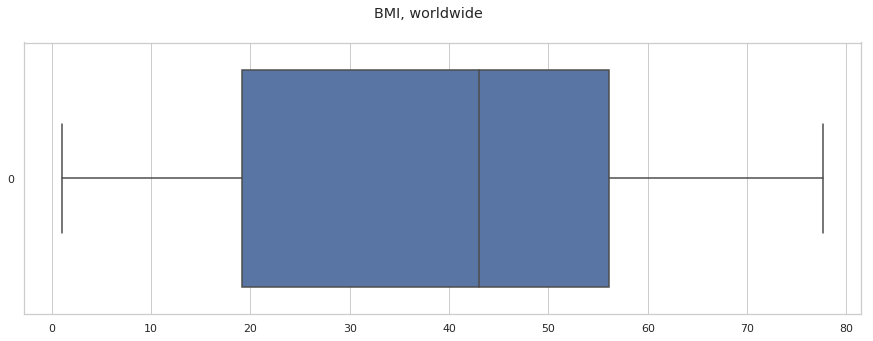

In [299]:
quick_boxplot(life_df['Bmi'],"BMI, worldwide",logscale=False)

BMI values for the US are well over twice what they should be, with two outlying values that are 10 times less than the other values.

In [300]:
life_df.loc[life_df['Country'] == 'United States of America',['Country','Year','Bmi']]#['Country'].value_counts()

,Country,Year,Bmi
2794,United States of America,2015,69.6
2795,United States of America,2014,69.1
2796,United States of America,2013,68.6
2797,United States of America,2012,68.0
2798,United States of America,2011,67.5
2799,United States of America,2010,66.9
2800,United States of America,2009,66.3
2801,United States of America,2008,65.7
2802,United States of America,2007,65.1
2803,United States of America,2006,64.4


In [301]:
life_df.loc[life_df['Bmi'] > 50,['Country','Year','Bmi']]['Country'].value_counts()

Malta                                        16
Qatar                                        16
Estonia                                      16
Sweden                                       16
Micronesia (Federated States of)             16
Denmark                                      16
Ireland                                      15
Cyprus                                       15
Slovakia                                     15
Kiribati                                     15
Poland                                       15
Spain                                        15
Serbia                                       15
Venezuela (Bolivarian Republic of)           15
Russian Federation                           15
Romania                                      15
Chile                                        15
Slovenia                                     15
Libya                                        15
Belarus                                      15
Hungary                                 

## Under-five deaths

This stat should be represented as number of deaths per 1000 population. There are a lot of large outliers here that may represent an actual number of cases.

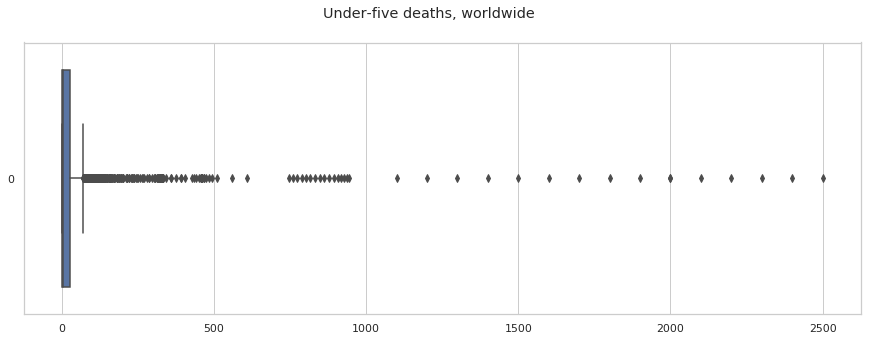

In [302]:
quick_boxplot(life_df['Under-five deaths'],"Under-five deaths, worldwide",logscale=False)

## Polio

Polio immunization coverage among 1-year olds, as a percentage. Valid vales are between 0-100.

There are some low outliers here but this seems mostly reasonable otherwise.

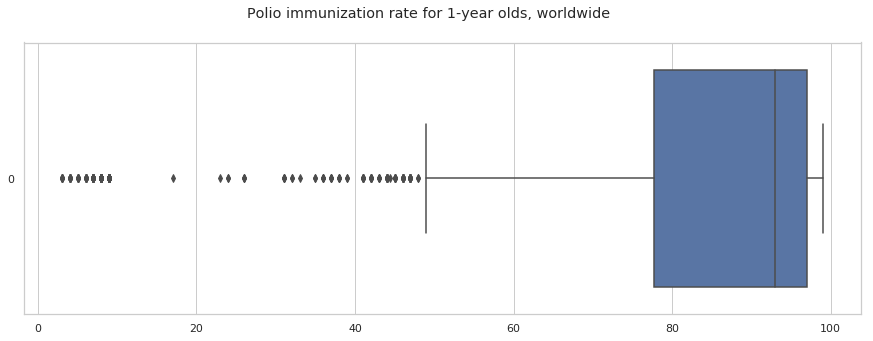

In [303]:
quick_boxplot(life_df['Polio'],"Polio immunization rate for 1-year olds, worldwide",logscale=False)

## Total expenditure

General government expenditure on health as a percentage of total government expenditure. 

The outliers here are not very high--still under 20%. There may not be much to do here?

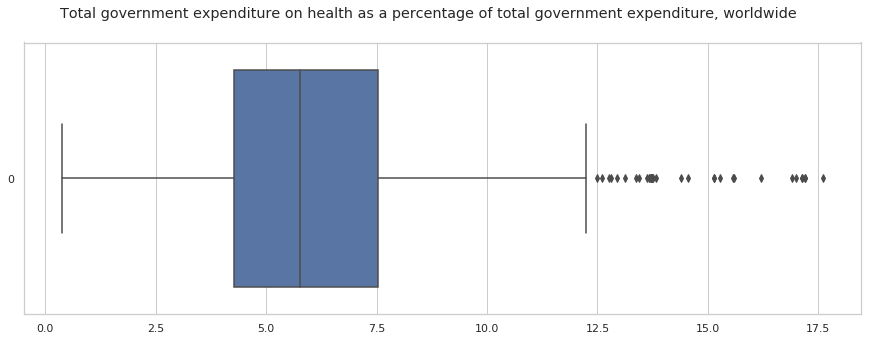

In [304]:
quick_boxplot(life_df['Total expenditure'],"Total government expenditure on health as a percentage of total government expenditure, worldwide",logscale=False)

## Diphtheria 

Diphtheria tetanus toxoid and pertussis (DTP3) immunization coverage among 1-year-olds, as a percentage.

Which countries do the low-end outliers represent? Upper limit looks good!

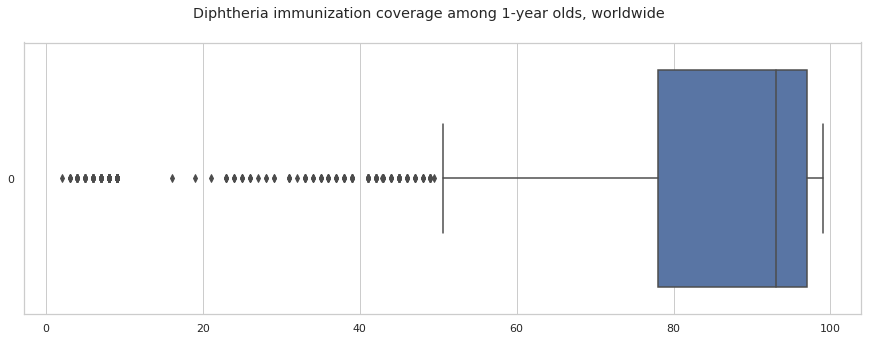

In [305]:
quick_boxplot(life_df['Diphtheria'],"Diphtheria immunization coverage among 1-year olds, worldwide",logscale=False)

## HIV/AIDS

Deaths per 1000 live births to HIV/AIDS (0-4 years).

I don't know--there are a large number of outliers here, but I think this is because the rate is so low for so many countries that the countries for whom this is a major issue appear to be outliers?

In [306]:
life_df['Hiv/aids'].describe()

count    2928.000000
mean        1.747712
std         5.085542
min         0.100000
25%         0.100000
50%         0.100000
75%         0.800000
max        50.600000
Name: Hiv/aids, dtype: float64

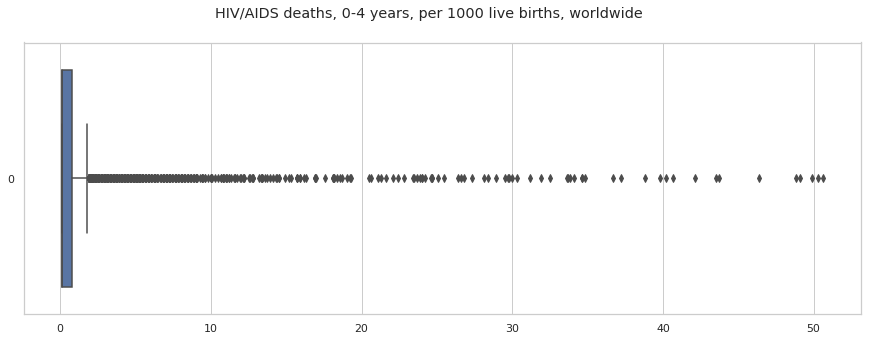

In [307]:
quick_boxplot(life_df['Hiv/aids'],"HIV/AIDS deaths, 0-4 years, per 1000 live births, worldwide",logscale=False)

## GDP

Gross Domestic Product per capita (in USD).

Pretty sure the minimum value of 1.68 is too low...

In [308]:
life_df['Gdp'].describe()

count      2928.000000
mean       7534.103755
std       13999.610301
min           1.681350
25%         496.568260
50%        1780.431605
75%        6285.631372
max      119172.741800
Name: Gdp, dtype: float64

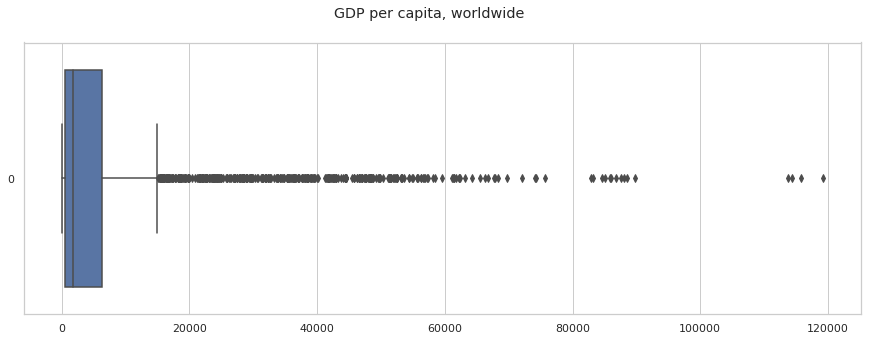

In [309]:
quick_boxplot(life_df['Gdp'],"GDP per capita, worldwide",logscale=False)

## Population

I filled in a lot of missing values for this category. The other thing I noticed that is wrong here is that the population for each country fluctuates wildly over the 2000-2015 period. It looks like in the cases I spot-checked that the values for some years needed to be multiplied by some power of 10 to bring them in line with the actual population totals.

China, for instance: China has over 1 billion people, so none of these numbers are correct.

In [310]:
life_df.loc[life_df['Country'] == 'China','Population']

560     137122.0
561     136427.0
562     135738.0
563     135695.0
564     134413.0
565     133775.0
566     133126.0
567    1324655.0
568    1317885.0
569      13112.0
570      13372.0
571     129675.0
572      12884.0
573       1284.0
574     127185.0
575    1262645.0
Name: Population, dtype: float64

In [311]:
life_df.loc[life_df['Country'] == 'China','Population'].describe()

count    1.600000e+01
mean     3.218121e+05
std      4.892337e+05
min      1.284000e+03
25%      9.873175e+04
50%      1.340940e+05
75%      1.366008e+05
max      1.324655e+06
Name: Population, dtype: float64

In [312]:
get_tukey(life_df.loc[life_df['Country'] == 'China'],'Population')

{1.0: [60862.75, 174469.75, 7],
 1.5: [41928.25, 193404.25, 7],
 2.0: [22993.75, 212338.75, 7],
 2.5: [4059.25, 231273.25, 4],
 3.0: [-14875.25, 250207.75, 3],
 3.5: [-33809.75, 269142.25, 3],
 4.0: [-52744.25, 288076.75, 3],
 4.5: [-71678.75, 307011.25, 3],
 5.0: [-90613.25, 325945.75, 3]}

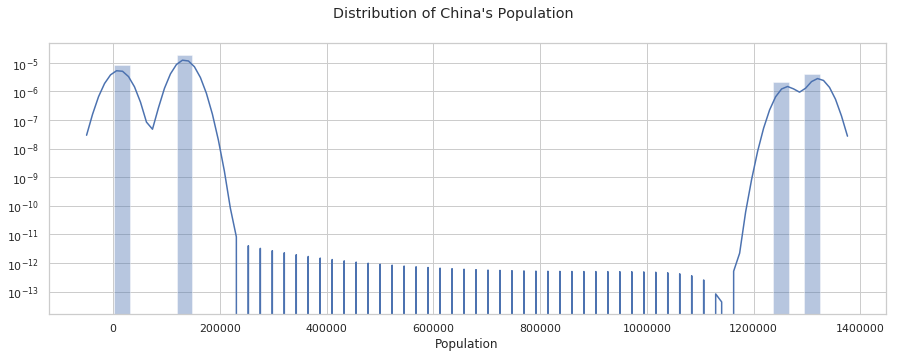

In [313]:
quick_distplot(life_df.loc[life_df['Country'] == 'China','Population'],"Distribution of China's Population")

The US looks totally fine, however:

In [314]:
life_df.loc[life_df['Country'] == 'United States of America','Population']

2794    320742673.0
2795    318386421.0
2796    316057727.0
2797    313874218.0
2798    311580009.0
2799    309326085.0
2800    306771529.0
2801    304093966.0
2802    301231207.0
2803    298379912.0
2804    295516599.0
2805    292805298.0
2806    290107933.0
2807    287625193.0
2808    284968955.0
2809    282162411.0
Name: Population, dtype: float64

In [315]:
get_tukey(life_df.loc[life_df['Country'] == 'United States of America'],'Population')

{1.0: [272108352.25, 332176165.75, 0],
 1.5: [262097050.0, 342187468.0, 0],
 2.0: [252085747.75, 352198770.25, 0],
 2.5: [242074445.5, 362210072.5, 0],
 3.0: [232063143.25, 372221374.75, 0],
 3.5: [222051841.0, 382232677.0, 0],
 4.0: [212040538.75, 392243979.25, 0],
 4.5: [202029236.5, 402255281.5, 0],
 5.0: [192017934.25, 412266583.75, 0]}

In [316]:
life_df.loc[life_df['Country'] == 'United States of America','Population'].describe()

count    1.600000e+01
mean     3.021019e+08
std      1.239024e+07
min      2.821624e+08
25%      2.921310e+08
50%      3.026626e+08
75%      3.121536e+08
max      3.207427e+08
Name: Population, dtype: float64

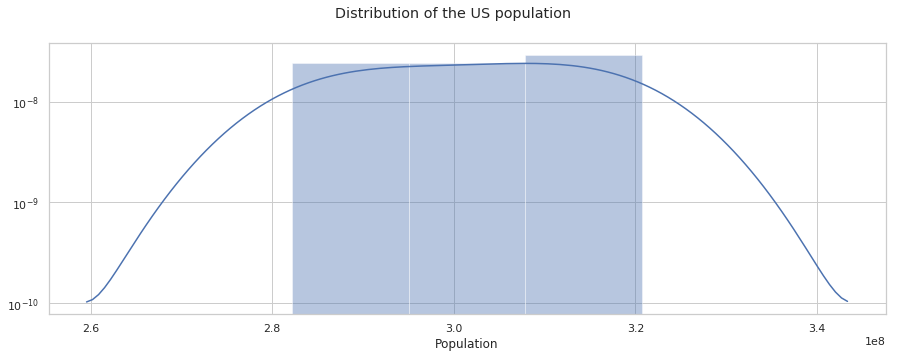

In [317]:
quick_distplot(life_df.loc[life_df['Country'] == 'United States of America','Population'],"Distribution of the US population")

It looks like we can use Tukey's method to identify the countries whose populations are messed up.

In [318]:
population_outliers = find_outliers(life_df,'Country','Population',return_outliers=True)

Country: Afghanistan: Found 0 outliers at threshold == 1.0: [-18803619.5, 43173840.25, 0]
Country: Albania: Found 3 outliers at threshold == 5.0: [-1443187.25, 1807854.5, 3]
{1.0: [-260990.25, 625657.5, 3], 1.5: [-408764.875, 773432.125, 3], 2.0: [-556539.5, 921206.75, 3], 2.5: [-704314.125, 1068981.375, 3], 3.0: [-852088.75, 1216756.0, 3], 3.5: [-999863.375, 1364530.625, 3], 4.0: [-1147638.0, 1512305.25, 3], 4.5: [-1295412.625, 1660079.875, 3], 5.0: [-1443187.25, 1807854.5, 3]}
Country: Algeria: Found 0 outliers at threshold == 1.0: [-30459579.25, 70738985.0, 0]
Country: Côte d'Ivoire: Found 0 outliers at threshold == 1.0: [14597257.75, 24438803.5, 0]
Country: Angola: Found 0 outliers at threshold == 1.0: [-14555853.0, 35834060.25, 0]
Country: Antigua and Barbuda: Found 0 outliers at threshold == 1.0: [70612.0, 99007.0, 0]
Country: Argentina: Found 0 outliers at threshold == 1.0: [-33678599.5, 78837504.5, 0]
Country: Armenia: Found 0 outliers at threshold == 1.0: [-2813423.5, 5720732.

Country: Ecuador: Found 0 outliers at threshold == 1.0: [-11976241.5, 28207313.25, 0]
Country: Egypt: Found 0 outliers at threshold == 1.0: [62668660.5, 96169416.0, 0]
Country: El Salvador: Found 0 outliers at threshold == 1.0: [-4917248.5, 11674794.5, 0]
Country: Slovakia: Found 0 outliers at threshold == 1.0: [5347937.25, 5427055.5, 0]
Country: Equatorial Guinea: Found 0 outliers at threshold == 1.0: [-543890.5, 1474187.0, 0]
Country: Eritrea: Found 0 outliers at threshold == 1.0: [-3499350.5, 8329006.75, 0]
Country: Estonia: Found 0 outliers at threshold == 1.0: [-1064440.0, 2530572.5, 0]
Country: Ethiopia: Found 0 outliers at threshold == 1.0: [-68765721.75, 159996959.25, 0]
Country: Fiji: Found 0 outliers at threshold == 3.0: [4952.75, 1464711.75, 0]
{1.0: [422026.75, 1047637.75, 4], 1.5: [317758.25, 1151906.25, 4], 2.0: [213489.75, 1256174.75, 4], 2.5: [109221.25, 1360443.25, 4], 3.0: [4952.75, 1464711.75, 0], 3.5: [-99315.75, 1568980.25, 0], 4.0: [-203584.25, 1673248.75, 0], 4.5

Country: Philippines: Found 0 outliers at threshold == 1.0: [-63129876.5, 152942852.5, 0]
Country: Poland: Found 0 outliers at threshold == 1.0: [-30501024.0, 72444966.0, 0]
Country: Portugal: Found 0 outliers at threshold == 1.0: [-1215133.0, 2882624.0, 0]
Country: Qatar: Found 0 outliers at threshold == 1.0: [-605026.75, 3416396.0, 0]
Country: Republic of Korea: Found 0 outliers at threshold == 1.0: [46067501.75, 51969911.75, 0]
Country: Republic of Moldova: Found 0 outliers at threshold == 1.0: [3513561.25, 3652485.25, 0]
Country: Romania: Found 0 outliers at threshold == 1.0: [-15983683.0, 38468378.0, 0]
Country: Russian Federation: Found 0 outliers at threshold == 1.0: [-120878542.0, 274964347.25, 0]
Country: Rwanda: Found 0 outliers at threshold == 1.0: [-7164851.75, 16875069.25, 0]
Country: Saint Lucia: Found 0 outliers at threshold == 1.0: [147169.5, 190144.5, 0]
Country: Saint Vincent and the Grenadines: Found 0 outliers at threshold == 2.0: [107625.5, 109259.25, 0]
{1.0: [107

In [319]:
population_outliers

['Albania',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bangladesh',
 'Belgium',
 'Chile',
 'China',
 'Comoros',
 'Croatia',
 'Cuba',
 'Denmark',
 'Djibouti',
 'Fiji',
 'Georgia',
 'Greece',
 'Hungary',
 'Ireland',
 'Japan',
 'Jordan',
 'Liberia',
 'Maldives',
 'Mexico',
 'Mongolia',
 'Oman',
 'Saint Vincent and the Grenadines',
 'Slovenia',
 'Switzerland',
 'The former Yugoslav republic of Macedonia',
 'Tonga',
 'Tunisia',
 'Ukraine']

## Thinness 10-19 years

Prevalence of thinness among children and adolescents for Age 10 to 19, expressed as a percentage.

This seems good at a glance.

In [320]:
life_df['Thinness 1-19 years'].describe()

count    2928.000000
mean        4.883487
std         4.409776
min         0.100000
25%         1.600000
50%         3.400000
75%         7.200000
max        27.700000
Name: Thinness 1-19 years, dtype: float64

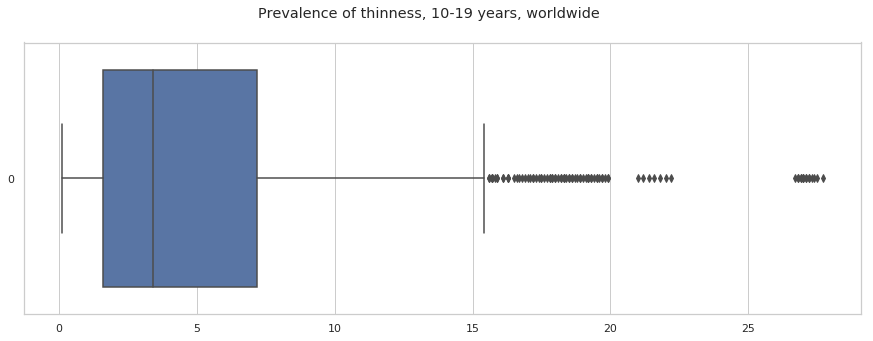

In [321]:
quick_boxplot(life_df['Thinness 1-19 years'],"Prevalence of thinness, 10-19 years, worldwide",logscale=False)

In [322]:
life_df.loc[life_df['Thinness 1-19 years'] > 15,['Country','Thinness 1-19 years']].groupby('Country').mean()

,Thinness 1-19 years
Country,
Afghanistan,18.635714
Bangladesh,18.900000
Bhutan,17.218750
India,27.100000
Namibia,15.450000
Nepal,17.131250
Pakistan,20.836364
South Africa,15.850000
Sri Lanka,15.325000


## Thinness 5-9 years

Prevalence of thinness among children for Age 5 to 9, expressed as a percentage. These percentages look close to those of the 10-19 group--also a good sign.

In [323]:
life_df['Thinness 5-9 years'].describe()

count    2928.000000
mean        4.907514
std         4.493659
min         0.100000
25%         1.600000
50%         3.400000
75%         7.300000
max        28.600000
Name: Thinness 5-9 years, dtype: float64

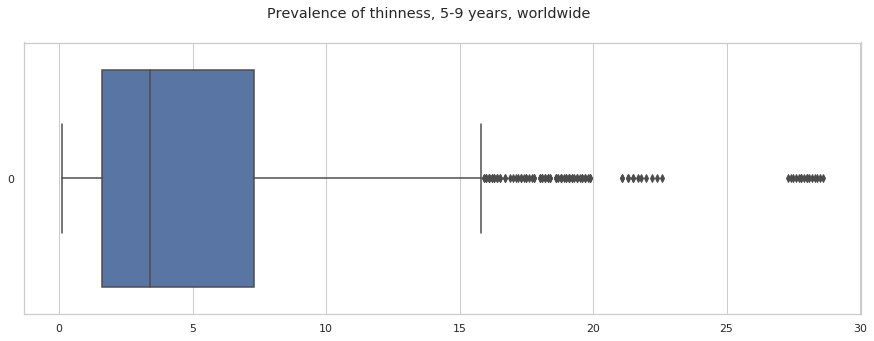

In [324]:
quick_boxplot(life_df['Thinness 5-9 years'],"Prevalence of thinness, 5-9 years, worldwide",logscale=False)

In [325]:
life_df.loc[life_df['Thinness 5-9 years'] > 15,['Country','Thinness 5-9 years']].groupby('Country').mean()

,Thinness 5-9 years
Country,
Afghanistan,18.630769
Bangladesh,19.709091
Bhutan,17.925000
India,27.943750
Namibia,15.650000
Nepal,17.668750
Pakistan,21.454545
South Africa,17.600000
Sri Lanka,15.421429


## Income composition of resources

Human Development Index in terms of income composition of resources (index ranging from 0 to 1).

There are a bunch of zeros for this variable, but they mostly appear to be countries who didn't exist in their current form as of the years in question (ex: the former Yugoslavian nations, before 2006).

Bhutan is one exception to this, missing values from 2000-2010.

The Bahamas have a zero for a single year, 2000.

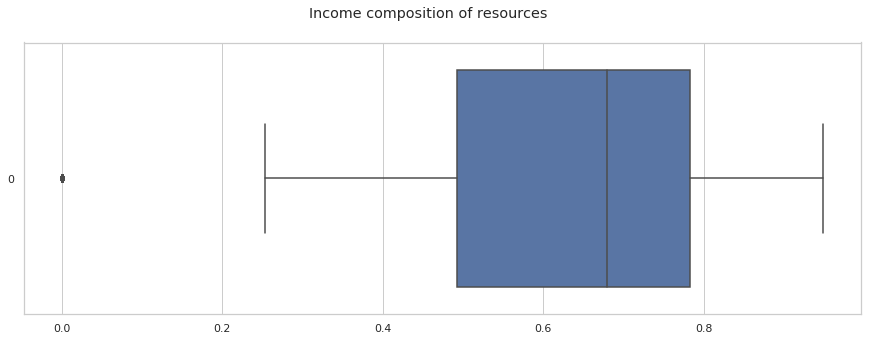

In [326]:
quick_boxplot(life_df['Income composition of resources'],"Income composition of resources",logscale=False)

In [327]:
life_df.loc[life_df['Country'] == 'Bhutan',['Country','Year','Income composition of resources']]

,Country,Year,Income composition of resources
289,Bhutan,2015,0.604
290,Bhutan,2014,0.596
291,Bhutan,2013,0.589
292,Bhutan,2012,0.581
293,Bhutan,2011,0.572
294,Bhutan,2010,0.000
295,Bhutan,2009,0.000
296,Bhutan,2008,0.000
297,Bhutan,2007,0.000
298,Bhutan,2006,0.000


In [328]:
life_df.loc[life_df['Country'] == 'Bahamas',['Country','Year','Income composition of resources']]

,Country,Year,Income composition of resources
161,Bahamas,2015,0.790
162,Bahamas,2014,0.789
163,Bahamas,2013,0.790
164,Bahamas,2012,0.789
165,Bahamas,2011,0.788
166,Bahamas,2010,0.788
167,Bahamas,2009,0.791
168,Bahamas,2008,0.791
169,Bahamas,2007,0.790
170,Bahamas,2006,0.788


In [329]:
life_df.loc[life_df['Income composition of resources'] == 0,['Country','Year','Income composition of resources']]

,Country,Year,Income composition of resources
75,Antigua and Barbuda,2005,0.0
76,Antigua and Barbuda,2004,0.0
77,Antigua and Barbuda,2003,0.0
78,Antigua and Barbuda,2002,0.0
79,Antigua and Barbuda,2001,0.0
80,Antigua and Barbuda,2000,0.0
176,Bahamas,2000,0.0
294,Bhutan,2010,0.0
295,Bhutan,2009,0.0
296,Bhutan,2008,0.0


## Schooling

Number of years of Schooling.

There are some zeroes here. The US is also horked (.92 years of Schooling? Pretty sure this is not correct.)

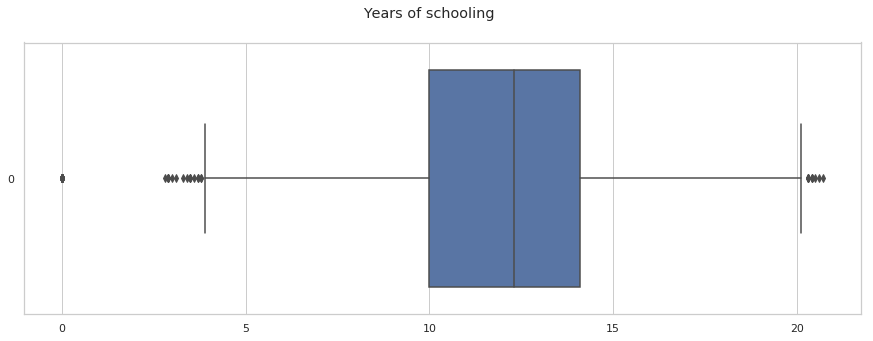

In [330]:
quick_boxplot(life_df['Schooling'],"Years of schooling",logscale=False)

In [332]:
life_df['Schooling'].describe()

count    2928.000000
mean       11.879058
std         3.388684
min         0.000000
25%        10.000000
50%        12.300000
75%        14.100000
max        20.700000
Name: Schooling, dtype: float64

In [333]:
life_df.loc[life_df['Schooling'] < 5,['Country','Year','Schooling']]

,Country,Year,Schooling
37,Côte d'Ivoire,2001,4.4442
64,Angola,2000,4.6000
75,Antigua and Barbuda,2005,0.0000
76,Antigua and Barbuda,2004,0.0000
77,Antigua and Barbuda,2003,0.0000
78,Antigua and Barbuda,2002,0.0000
79,Antigua and Barbuda,2001,0.0000
80,Antigua and Barbuda,2000,0.0000
336,Bosnia and Herzegovina,2000,0.0000
409,Burkina Faso,2007,4.9000



Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.